In [1]:
%pylab inline
from collections import OrderedDict
import tensorflow as tf
ds = tf.contrib.distributions
slim = tf.contrib.slim
        
from keras.optimizers import Adam

try:
    from moviepy.video.io.bindings import mplfig_to_npimage
    import moviepy.editor as mpy
    generate_movie = True
except:
    print("Warning: moviepy not found.")
    generate_movie = False

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Using TensorFlow backend.


In [2]:
_graph_replace = tf.contrib.graph_editor.graph_replace

def remove_original_op_attributes(graph):
    """Remove _original_op attribute from all operations in a graph."""
    for op in graph.get_operations():
        op._original_op = None
        
def graph_replace(*args, **kwargs):
    """Monkey patch graph_replace so that it works with TF 1.0"""
    remove_original_op_attributes(tf.get_default_graph())
    return _graph_replace(*args, **kwargs)

### Utility functions

In [3]:
def extract_update_dict(update_ops):
    """Extract variables and their new values from Assign and AssignAdd ops.
    
    Args:
        update_ops: list of Assign and AssignAdd ops, typically computed using Keras' opt.get_updates()

    Returns:
        dict mapping from variable values to their updated value
    """
    name_to_var = {v.name: v for v in tf.global_variables()}
    updates = OrderedDict()
    for update in update_ops:
        var_name = update.op.inputs[0].name
        var = name_to_var[var_name]
        value = update.op.inputs[1]
        if update.op.type == 'Assign':
            updates[var.value()] = value
        elif update.op.type == 'AssignAdd':
            updates[var.value()] = var + value
        #else:
        #    raise ValueError("Update op type (%s) must be of type Assign or AssignAdd"%update_op.op.type)
    return updates

### Data creation

In [4]:
def sample_mog(batch_size, n_mixture=5, std=0.01, radius=1.0):
    thetas = np.linspace(0, 2 * np.pi, n_mixture)
    xs, ys = radius * np.sin(thetas), radius * np.cos(thetas)
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

### Generator and discriminator architectures

In [5]:
def generator(z, output_dim=2, n_hidden=128, n_layer=2):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)#tf.nn.tanh)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=128, n_layer=2, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)#tf.nn.tanh)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Hyperparameters

In [6]:
params = dict(
    batch_size=512,
    disc_learning_rate=1e-4,
    gen_learning_rate=1e-3,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=1500,
    viz_every=100,
    z_dim=256,
    x_dim=2,
    unrolling_steps=0,
    disc_steps = 6,
    rate = 4,
)

## Construct model and training ops

In [7]:
tf.reset_default_graph()

data = sample_mog(params['batch_size'])

noise = ds.Normal(tf.zeros(params['z_dim']), 
                  tf.ones(params['z_dim'])).sample(params['batch_size'])
# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=0.8)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
#disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

# Vanilla discriminator update: for loop is to take many discriminator steps
#for disc_steps  in range(0, 10):
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
d_opt = Adam(lr=params['disc_learning_rate'], beta_1=params['beta1'], epsilon=params['epsilon'])
updates = d_opt.get_updates(disc_vars, [], loss)
d_train_op = tf.group(*updates, name="d_train_op")




    
# Unroll optimization of the discrimiantor
if params['unrolling_steps'] > 0:
    # Get dictionary mapping from variables to their update value after one optimization step
    update_dict = extract_update_dict(updates)
    cur_update_dict = update_dict
    for i in range(params['unrolling_steps'] - 1):
        # Compute variable updates given the previous iteration's updated variable
        cur_update_dict = graph_replace(update_dict, cur_update_dict)
    # Final unrolled loss uses the parameters at the last time step
    unrolled_loss = graph_replace(loss, cur_update_dict)
else:
    unrolled_loss = loss

# Optimize the generator on the unrolled loss
g_train_opt = tf.train.AdamOptimizer(params['gen_learning_rate'], beta1=params['beta1'], epsilon=params['epsilon'])
g_train_op = g_train_opt.minimize(-unrolled_loss, var_list=gen_vars)

# Optimize the Vanilla generator on the non-unrolled loss
g_train_op_vanilla = g_train_opt.minimize(-loss, var_list=gen_vars)




#make a copy of the weights
disc_vars_copy = [tf.identity(disc_vars[0]), tf.identity(disc_vars[1]), tf.identity(disc_vars[2]), tf.identity(disc_vars[3]), tf.identity(disc_vars[4]), tf.identity(disc_vars[5])]
gen_vars_copy = [tf.identity(gen_vars[0]), tf.identity(gen_vars[1]), tf.identity(gen_vars[2]), tf.identity(gen_vars[3]), tf.identity(gen_vars[4]), tf.identity(gen_vars[5])]

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.contrib.distributions`.
Instructions for updating:
The TensorFlo

In [8]:
##Note: I didn't end up using this function noise

def add_random_noise(w, mean=0.0, stddev=0.0):
    variables_shape = tf.shape(w)
    noise = tf.random_normal(
        variables_shape,
        mean=mean,
        stddev=stddev,
        dtype=tf.float32,
    )
    return tf.assign_add(w, noise)

## Train!

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/1500 [00:00<?, ?it/s]

[1.3864198]


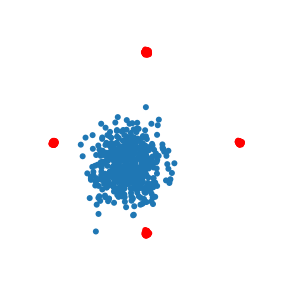

  0%|          | 5/1500 [00:00<10:00,  2.49it/s]

accept
[[1.3864198], [1.382791]]
accept
[[1.382791], [1.3778666]]
accept
[[1.3778666], [1.3723924]]
accept
[[1.3686221], [1.3682656]]
accept
[[1.3682656], [1.3669844]]
reject


  1%|          | 10/1500 [00:01<05:48,  4.28it/s]

[[1.3669844], [1.3675461]]
reject
[[1.3583832], [1.3658262]]
accept
[[1.3658262], [1.3631681]]


  1%|          | 12/1500 [00:01<04:39,  5.32it/s]

reject
[[1.3631681], [1.3756222]]
reject


  1%|          | 16/1500 [00:01<03:18,  7.47it/s]

[[1.3700578], [1.3792536]]
accept
[[1.3792536], [1.3685908]]
reject
[[1.3685908], [1.3703308]]


  1%|          | 18/1500 [00:01<02:56,  8.40it/s]

reject
[[1.3603764], [1.3620256]]
accept
[[1.3620256], [1.3519697]]
reject


  1%|▏         | 22/1500 [00:02<02:30,  9.80it/s]

[[1.3519697], [1.3598427]]
reject
[[1.3558023], [1.3780403]]
accept
[[1.3780403], [1.3708401]]


  2%|▏         | 24/1500 [00:02<02:23, 10.28it/s]

reject
[[1.3708401], [1.3906407]]
reject


  2%|▏         | 28/1500 [00:02<02:14, 10.94it/s]

[[1.3768291], [1.389893]]
accept
[[1.389893], [1.3705647]]
reject
[[1.3705647], [1.391736]]


  2%|▏         | 30/1500 [00:02<02:11, 11.15it/s]

reject
[[1.3684759], [1.38284]]
accept
[[1.38284], [1.3624747]]
accept
[[1.3624747], [1.3579016]]


  2%|▏         | 35/1500 [00:02<01:41, 14.50it/s]

accept
[[1.3453135], [1.3197582]]
accept
[[1.3197582], [1.3064854]]
accept
[[1.3064854], [1.3041946]]
reject


  3%|▎         | 41/1500 [00:03<01:37, 14.95it/s]

[[1.3227074], [1.3438349]]
accept
[[1.3438349], [1.3209112]]
reject
[[1.3209112], [1.35145]]


  3%|▎         | 43/1500 [00:03<01:47, 13.60it/s]

reject
[[1.3318448], [1.3619444]]
accept
[[1.3619444], [1.3411057]]
reject


  3%|▎         | 45/1500 [00:03<01:54, 12.68it/s]

[[1.3411057], [1.3914013]]
reject
[[1.3719823], [1.4314876]]


  3%|▎         | 49/1500 [00:03<02:04, 11.64it/s]

accept
[[1.4314876], [1.4133315]]
reject
[[1.4133315], [1.4464102]]


  4%|▎         | 54/1500 [00:04<01:35, 15.09it/s]

accept
[[1.4306971], [1.427618]]
accept
[[1.427618], [1.4101858]]
accept
[[1.4101858], [1.3852911]]
accept
[[1.3581474], [1.3446193]]
accept
[[1.3446193], [1.3326066]]
reject


  4%|▍         | 57/1500 [00:04<01:36, 15.00it/s]

[[1.3326066], [1.3327758]]
reject
[[1.3273143], [1.3397933]]


  4%|▍         | 60/1500 [00:04<01:57, 12.24it/s]

accept
[[1.3397933], [1.3297515]]
reject
[[1.3297515], [1.3526454]]


  4%|▍         | 62/1500 [00:04<02:03, 11.62it/s]

reject
[[1.3448043], [1.369776]]
accept
[[1.369776], [1.368021]]
reject


  4%|▍         | 66/1500 [00:05<02:11, 10.94it/s]

[[1.368021], [1.3856122]]
reject
[[1.383211], [1.391101]]


  5%|▍         | 68/1500 [00:05<02:14, 10.66it/s]

accept
[[1.391101], [1.3815334]]
reject
[[1.3815334], [1.3874315]]


  5%|▌         | 78/1500 [00:05<01:20, 17.72it/s]

accept
[[1.3782655], [1.378251]]
accept
[[1.378251], [1.3768945]]
accept
[[1.3768945], [1.3739108]]
accept
[[1.3681713], [1.3527917]]
accept
[[1.3527917], [1.3406411]]
accept
[[1.3406411], [1.3280914]]
accept
[[1.3183244], [1.3059356]]
reject
[[1.3059356], [1.3087182]]
accept
[[1.3087182], [1.3068061]]
reject


  5%|▌         | 82/1500 [00:06<01:52, 12.55it/s]

[[1.3252687], [1.3514652]]
accept
[[1.3514652], [1.3404737]]
reject
[[1.3404737], [1.3645253]]


  6%|▌         | 85/1500 [00:06<01:49, 12.94it/s]

reject
[[1.3543787], [1.3785679]]
accept
[[1.3785679], [1.3738431]]
reject


  6%|▌         | 88/1500 [00:06<02:08, 10.98it/s]

[[1.3738431], [1.3858218]]
reject


  6%|▌         | 92/1500 [00:07<02:14, 10.47it/s]

[[1.3847332], [1.4077262]]
accept
[[1.4077262], [1.3887535]]
reject
[[1.3887535], [1.4044006]]


  6%|▋         | 94/1500 [00:07<02:15, 10.35it/s]

reject
[[1.3882973], [1.3961005]]
accept
[[1.3961005], [1.376175]]
accept
[[1.376175], [1.3688624]]


  7%|▋         | 99/1500 [00:07<01:43, 13.54it/s]

accept
[[1.349871], [1.3266354]]
accept
[[1.3266354], [1.3069905]]
accept
[[1.3069905], [1.2957275]]
[1.2891753]


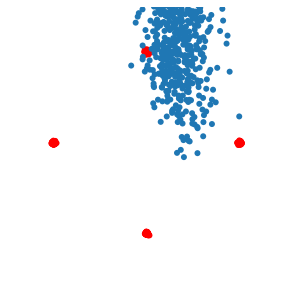

  7%|▋         | 102/1500 [00:07<01:55, 12.05it/s]

accept
[[1.2891753], [1.2880067]]
reject
[[1.2880067], [1.288963]]


  7%|▋         | 104/1500 [00:08<02:39,  8.74it/s]

reject
[[1.288963], [1.2901154]]


  7%|▋         | 106/1500 [00:08<02:33,  9.08it/s]

reject
[[1.296544], [1.3169363]]
accept
[[1.3169363], [1.3068587]]


  7%|▋         | 108/1500 [00:08<02:31,  9.20it/s]

reject
[[1.3068587], [1.3377404]]


  7%|▋         | 110/1500 [00:08<02:27,  9.42it/s]

reject
[[1.3342276], [1.3840933]]
reject


  7%|▋         | 112/1500 [00:08<02:26,  9.48it/s]

[[1.3840933], [1.3858445]]
accept
[[1.3858445], [1.3656803]]
reject


  8%|▊         | 119/1500 [00:09<01:49, 12.60it/s]

[[1.3971738], [1.414545]]
accept
[[1.414545], [1.3883693]]
accept
[[1.3883693], [1.3777456]]
accept
[[1.3557204], [1.3217765]]
accept
[[1.3217765], [1.3027453]]
accept
[[1.3027453], [1.2914546]]
reject


  8%|▊         | 122/1500 [00:09<01:48, 12.70it/s]

[[1.2995465], [1.3076346]]
accept
[[1.3076346], [1.2832958]]
reject


  8%|▊         | 124/1500 [00:09<01:58, 11.64it/s]

[[1.2832958], [1.298754]]
reject


  8%|▊         | 126/1500 [00:09<02:06, 10.89it/s]

[[1.2632802], [1.295188]]
reject
[[1.295188], [1.2980609]]


  9%|▊         | 128/1500 [00:10<02:11, 10.47it/s]

accept
[[1.2980609], [1.2678655]]
reject


  9%|▊         | 130/1500 [00:10<02:15, 10.08it/s]

[[1.3229353], [1.3584152]]
reject
[[1.3584152], [1.363766]]


  9%|▉         | 132/1500 [00:10<02:18,  9.89it/s]

accept
[[1.363766], [1.3288811]]
accept
[[1.3869319], [1.3793719]]
reject


  9%|▉         | 135/1500 [00:10<02:08, 10.59it/s]

[[1.3793719], [1.3915397]]
accept
[[1.3915397], [1.347919]]
accept
[[1.3398981], [1.3162587]]
reject


  9%|▉         | 139/1500 [00:10<01:55, 11.74it/s]

[[1.3162587], [1.3233374]]
accept
[[1.3233374], [1.3085961]]
reject


  9%|▉         | 142/1500 [00:11<01:53, 11.97it/s]

[[1.335693], [1.3904057]]
accept
[[1.3904057], [1.3661137]]
reject


 10%|▉         | 144/1500 [00:11<02:05, 10.84it/s]

[[1.3661137], [1.391128]]
accept
[[1.3774151], [1.3742024]]
reject


 10%|▉         | 147/1500 [00:11<01:59, 11.31it/s]

[[1.3742024], [1.3756309]]
accept
[[1.3756309], [1.356896]]
reject


 10%|█         | 150/1500 [00:11<01:55, 11.64it/s]

[[1.3599659], [1.3718979]]
accept
[[1.3718979], [1.358912]]
reject


 10%|█         | 152/1500 [00:12<02:06, 10.69it/s]

[[1.358912], [1.3694829]]
reject


 10%|█         | 154/1500 [00:12<02:13, 10.12it/s]

[[1.3583635], [1.3799765]]
accept
[[1.3799765], [1.3678306]]
reject


 11%|█         | 161/1500 [00:12<01:43, 12.88it/s]

[[1.3678306], [1.3761339]]
accept
[[1.3642005], [1.3629922]]
accept
[[1.3629922], [1.3601227]]
accept
[[1.3601227], [1.3537819]]
accept
[[1.3414791], [1.3326602]]
accept
[[1.3326602], [1.3196919]]
accept
[[1.3196919], [1.3162692]]


 11%|█         | 166/1500 [00:12<01:20, 16.52it/s]

accept
[[1.3068597], [1.3044674]]
reject


 11%|█▏        | 169/1500 [00:13<01:29, 14.95it/s]

[[1.3044674], [1.3060501]]
accept
[[1.3060501], [1.3036524]]
reject
[[1.3029406], [1.3159039]]
accept
[[1.3159039], [1.308412]]
reject


 11%|█▏        | 172/1500 [00:13<01:58, 11.23it/s]

[[1.308412], [1.311954]]
reject


 12%|█▏        | 174/1500 [00:13<02:08, 10.33it/s]

[[1.3142744], [1.3277279]]
accept
[[1.3277279], [1.3130836]]
reject


 12%|█▏        | 176/1500 [00:13<02:15,  9.81it/s]

[[1.3130836], [1.3275952]]
reject


 12%|█▏        | 178/1500 [00:14<02:20,  9.42it/s]

[[1.3217683], [1.334238]]
accept
[[1.334238], [1.3223382]]
reject


 12%|█▏        | 180/1500 [00:14<02:22,  9.24it/s]

[[1.3223382], [1.3363278]]
reject


 12%|█▏        | 187/1500 [00:14<01:48, 12.09it/s]

[[1.3258681], [1.3283422]]
accept
[[1.3283422], [1.3157475]]
accept
[[1.3157475], [1.3153682]]
accept
[[1.2984121], [1.2888423]]
accept
[[1.2888423], [1.2727334]]
accept
[[1.2727334], [1.2416945]]
accept
[[1.2165512], [1.1884873]]
accept
[[1.1884873], [1.1705788]]


 13%|█▎        | 192/1500 [00:15<01:38, 13.25it/s]

reject
[[1.1705788], [1.1727343]]
reject
[[1.1695409], [1.2026415]]


 13%|█▎        | 195/1500 [00:15<01:41, 12.88it/s]

accept
[[1.2026415], [1.1956859]]
reject


 13%|█▎        | 197/1500 [00:15<01:56, 11.18it/s]

[[1.1956859], [1.2212657]]
reject


 13%|█▎        | 199/1500 [00:15<02:06, 10.30it/s]

[[1.2387657], [1.3062775]]
accept
[[1.3062775], [1.3026526]]
reject
[[1.3026526], [1.3662261]]
[1.3598092]


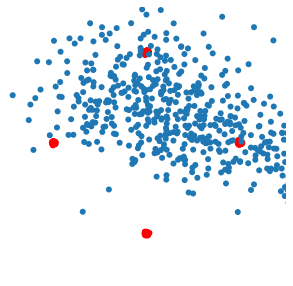

 13%|█▎        | 201/1500 [00:16<03:04,  7.05it/s]

reject
[[1.3598092], [1.4093454]]


 14%|█▎        | 203/1500 [00:16<02:55,  7.37it/s]

accept
[[1.4093454], [1.3777759]]
reject


 14%|█▍        | 209/1500 [00:16<02:30,  8.57it/s]

[[1.3777759], [1.4004543]]
accept
[[1.3625336], [1.3530709]]
accept
[[1.3530709], [1.3441491]]
accept
[[1.3441491], [1.3432884]]
accept
[[1.3338976], [1.32842]]
accept
[[1.32842], [1.2975144]]
accept
[[1.2975144], [1.2908248]]


 14%|█▍        | 214/1500 [00:16<01:52, 11.38it/s]

accept
[[1.2681545], [1.2672629]]
accept
[[1.2672629], [1.2640934]]
reject


 14%|█▍        | 217/1500 [00:17<01:51, 11.47it/s]

[[1.2640934], [1.2826815]]
reject
[[1.2718807], [1.2889807]]
accept
[[1.2889807], [1.2848055]]
reject


 15%|█▍        | 220/1500 [00:17<02:18,  9.27it/s]

[[1.2848055], [1.3106952]]
reject


 15%|█▍        | 222/1500 [00:17<02:22,  8.99it/s]

[[1.2993633], [1.3312521]]
accept
[[1.3312521], [1.3148623]]
reject


 15%|█▍        | 224/1500 [00:18<02:26,  8.73it/s]

[[1.3148623], [1.3486552]]
reject


 15%|█▌        | 226/1500 [00:18<02:28,  8.59it/s]

[[1.339466], [1.3822759]]
accept
[[1.3822759], [1.3664091]]
reject


 15%|█▌        | 228/1500 [00:18<02:29,  8.52it/s]

[[1.3664091], [1.3988919]]
reject


 16%|█▌        | 235/1500 [00:18<01:54, 11.09it/s]

[[1.3624353], [1.3733584]]
accept
[[1.3733584], [1.3370264]]
accept
[[1.3370264], [1.3283055]]
accept
[[1.3178933], [1.3010707]]
accept
[[1.3010707], [1.2821686]]
accept
[[1.2821686], [1.2670164]]
accept
[[1.2907257], [1.2872996]]
reject


 16%|█▌        | 239/1500 [00:19<01:47, 11.74it/s]

[[1.2872996], [1.3091232]]
accept
[[1.3091232], [1.2896614]]
accept
[[1.3056479], [1.3022268]]
reject


 16%|█▌        | 243/1500 [00:19<01:42, 12.30it/s]

[[1.3022268], [1.3127098]]
accept
[[1.3127098], [1.3059201]]
accept
[[1.2927146], [1.2843308]]
reject


 16%|█▋        | 247/1500 [00:19<01:38, 12.72it/s]

[[1.2843308], [1.286036]]
accept
[[1.286036], [1.2761823]]
accept
[[1.26512], [1.261847]]
accept
[[1.261847], [1.2595673]]
reject


 17%|█▋        | 252/1500 [00:20<01:31, 13.62it/s]

[[1.2595673], [1.2666885]]
accept
[[1.2538707], [1.252722]]
reject


 17%|█▋        | 255/1500 [00:20<01:37, 12.72it/s]

[[1.252722], [1.2584567]]
accept
[[1.2584567], [1.2385027]]
accept
[[1.2576559], [1.2490778]]
accept
[[1.2490778], [1.2434335]]
reject


 18%|█▊        | 265/1500 [00:20<01:11, 17.38it/s]

[[1.2434335], [1.2456775]]
accept
[[1.2483525], [1.241847]]
accept
[[1.241847], [1.238037]]
accept
[[1.238037], [1.235405]]
accept
[[1.2254171], [1.2230377]]
reject


 18%|█▊        | 268/1500 [00:21<01:22, 14.87it/s]

[[1.2230377], [1.2246841]]
accept
[[1.2246841], [1.2243117]]
reject


 18%|█▊        | 271/1500 [00:21<01:31, 13.44it/s]

[[1.2207963], [1.2213852]]
accept
[[1.2213852], [1.2165651]]
reject


 18%|█▊        | 273/1500 [00:21<01:49, 11.21it/s]

[[1.2165651], [1.219933]]
accept
[[1.2143165], [1.2133377]]
reject


 18%|█▊        | 275/1500 [00:21<02:03,  9.92it/s]

[[1.2133377], [1.2234696]]
reject


 18%|█▊        | 277/1500 [00:22<02:12,  9.26it/s]

[[1.2234696], [1.2273142]]
reject
[[1.224755], [1.2292808]]
reject


 19%|█▊        | 279/1500 [00:22<02:57,  6.87it/s]

[[1.2292808], [1.231535]]
reject


 19%|█▊        | 280/1500 [00:22<03:31,  5.77it/s]

[[1.231535], [1.2326012]]
reject


 19%|█▉        | 282/1500 [00:23<03:17,  6.17it/s]

[[1.2275159], [1.2403182]]
accept
[[1.2403182], [1.2256863]]
reject


 19%|█▉        | 284/1500 [00:23<03:06,  6.52it/s]

[[1.2256863], [1.2596234]]
accept
[[1.2695292], [1.2665548]]
reject


 19%|█▉        | 287/1500 [00:23<02:44,  7.39it/s]

[[1.2665548], [1.3090016]]
accept
[[1.3090016], [1.2903826]]
reject


 19%|█▉        | 290/1500 [00:23<02:30,  8.04it/s]

[[1.3483869], [1.3741008]]
accept
[[1.3741008], [1.3342687]]
reject


 19%|█▉        | 292/1500 [00:24<02:33,  7.87it/s]

[[1.3342687], [1.3764231]]
reject


 20%|█▉        | 299/1500 [00:24<02:00,  9.97it/s]

[[1.3332521], [1.3383857]]
accept
[[1.3383857], [1.3190515]]
accept
[[1.3190515], [1.3185418]]
accept
[[1.3008232], [1.2759749]]
accept
[[1.2759749], [1.2543578]]
accept
[[1.2543578], [1.2305518]]
[1.2240427]


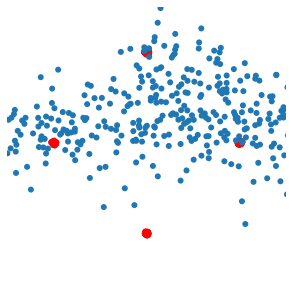

 20%|██        | 302/1500 [00:24<02:02,  9.77it/s]

accept
[[1.2240427], [1.2053661]]
accept
[[1.2053661], [1.1981354]]
accept
[[1.1981354], [1.1979563]]
reject


 20%|██        | 306/1500 [00:25<01:52, 10.57it/s]

[[1.1771959], [1.2000171]]
accept
[[1.2000171], [1.1911552]]
accept
[[1.1911552], [1.1795862]]
accept
[[1.1875744], [1.1768867]]
reject


 21%|██        | 311/1500 [00:25<01:42, 11.57it/s]

[[1.1768867], [1.1940802]]
reject


 21%|██        | 313/1500 [00:25<01:57, 10.06it/s]

[[1.1940802], [1.2034363]]
reject


 21%|██        | 315/1500 [00:26<02:10,  9.11it/s]

[[1.1758103], [1.2198957]]
accept
[[1.2198957], [1.1983885]]
reject


 21%|██        | 317/1500 [00:26<02:18,  8.57it/s]

[[1.1983885], [1.2214735]]
reject


 21%|██▏       | 319/1500 [00:26<02:23,  8.21it/s]

[[1.2147008], [1.21736]]
accept
[[1.21736], [1.1987404]]
reject


 21%|██▏       | 320/1500 [00:26<03:12,  6.13it/s]

[[1.1987404], [1.2179273]]
accept
[[1.2105165], [1.2047602]]
reject


 22%|██▏       | 323/1500 [00:27<02:48,  6.98it/s]

[[1.2047602], [1.2125221]]
accept
[[1.2125221], [1.2009971]]
reject


 22%|██▏       | 326/1500 [00:27<02:32,  7.70it/s]

[[1.2068567], [1.2170613]]
accept
[[1.2170613], [1.2059257]]
reject


 22%|██▏       | 328/1500 [00:27<02:33,  7.63it/s]

[[1.2059257], [1.2125905]]
accept
[[1.2331617], [1.2187815]]
reject


 22%|██▏       | 331/1500 [00:27<02:22,  8.21it/s]

[[1.2187815], [1.235291]]
accept
[[1.235291], [1.2128536]]
reject


 23%|██▎       | 339/1500 [00:28<01:39, 11.62it/s]

[[1.233427], [1.2430952]]
accept
[[1.2430952], [1.2377472]]
accept
[[1.2377472], [1.2253594]]
accept
[[1.2533503], [1.2271476]]
accept
[[1.2271476], [1.2210264]]
accept
[[1.2210264], [1.2087156]]
accept
[[1.2078527], [1.1920161]]
accept
[[1.1920161], [1.1842946]]
reject


 23%|██▎       | 344/1500 [00:28<01:33, 12.40it/s]

[[1.1842946], [1.1911678]]
reject


 23%|██▎       | 346/1500 [00:29<01:53, 10.15it/s]

[[1.1662171], [1.1718943]]
accept
[[1.1718943], [1.1658674]]
accept
[[1.1658674], [1.1479754]]
accept
[[1.1608832], [1.1399357]]
reject


 23%|██▎       | 351/1500 [00:29<01:43, 11.15it/s]

[[1.1399357], [1.1551069]]
reject


 24%|██▎       | 353/1500 [00:29<01:58,  9.67it/s]

[[1.1551069], [1.1594415]]
accept
[[1.1352216], [1.132383]]
accept
[[1.132383], [1.1217828]]
reject


 24%|██▎       | 356/1500 [00:29<01:57,  9.73it/s]

[[1.1217828], [1.1336391]]
reject


 24%|██▍       | 358/1500 [00:30<02:10,  8.72it/s]

[[1.1041796], [1.1137457]]
accept
[[1.1137457], [1.1057105]]
reject


 24%|██▍       | 360/1500 [00:30<02:22,  8.02it/s]

[[1.1057105], [1.1146753]]
accept
[[1.1044452], [1.0883808]]
accept
[[1.0883808], [1.0806751]]
reject


 24%|██▍       | 364/1500 [00:30<02:06,  9.01it/s]

[[1.0806751], [1.1020433]]
reject


 24%|██▍       | 366/1500 [00:31<02:15,  8.34it/s]

[[1.0829232], [1.1083871]]
accept
[[1.1083871], [1.068994]]
reject


 25%|██▍       | 368/1500 [00:31<02:25,  7.79it/s]

[[1.068994], [1.0845641]]
reject


 25%|██▍       | 370/1500 [00:31<02:34,  7.33it/s]

[[1.0786935], [1.0971609]]
accept
[[1.0971609], [1.066685]]
reject


 25%|██▍       | 372/1500 [00:32<02:41,  6.98it/s]

[[1.066685], [1.09952]]
accept
[[1.091693], [1.0900967]]
reject


 25%|██▌       | 375/1500 [00:32<02:27,  7.64it/s]

[[1.0900967], [1.1143063]]
accept
[[1.1143063], [1.0813247]]
reject


 25%|██▌       | 378/1500 [00:32<02:17,  8.17it/s]

[[1.1173377], [1.1177782]]
accept
[[1.1177782], [1.0951803]]
reject


 25%|██▌       | 380/1500 [00:32<02:27,  7.60it/s]

[[1.0951803], [1.1024566]]
accept
[[1.1033715], [1.0959344]]
reject


 26%|██▌       | 383/1500 [00:33<02:18,  8.08it/s]

[[1.0959344], [1.0994465]]
accept
[[1.0994465], [1.0765405]]
reject


 26%|██▌       | 386/1500 [00:33<02:12,  8.39it/s]

[[1.1138264], [1.130853]]
accept
[[1.130853], [1.1150312]]
reject


 26%|██▌       | 388/1500 [00:33<02:22,  7.78it/s]

[[1.1150312], [1.1602644]]
reject


 26%|██▌       | 390/1500 [00:34<02:27,  7.51it/s]

[[1.1276143], [1.1546805]]
accept
[[1.1546805], [1.1263764]]
reject


 26%|██▌       | 392/1500 [00:34<02:33,  7.21it/s]

[[1.1263764], [1.1759574]]
reject


 27%|██▋       | 399/1500 [00:34<01:55,  9.53it/s]

[[1.1326194], [1.1525617]]
accept
[[1.1525617], [1.1347094]]
accept
[[1.1347094], [1.1204287]]
accept
[[1.1077545], [1.096556]]
accept
[[1.096556], [1.090847]]
reject
[[1.090847], [1.0963]]
[1.0690354]


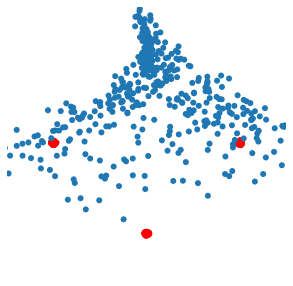

 27%|██▋       | 401/1500 [00:35<02:52,  6.35it/s]

accept
[[1.0690354], [1.059686]]
accept
[[1.059686], [1.0418923]]
reject


 27%|██▋       | 404/1500 [00:35<02:35,  7.03it/s]

[[1.0418923], [1.0539355]]
accept
[[1.060685], [1.0531352]]
reject


 27%|██▋       | 407/1500 [00:36<02:24,  7.59it/s]

[[1.0531352], [1.0568838]]
reject


 27%|██▋       | 409/1500 [00:36<02:29,  7.31it/s]

[[1.0568838], [1.070087]]
reject


 27%|██▋       | 411/1500 [00:36<02:33,  7.09it/s]

[[1.037898], [1.0542774]]
accept
[[1.0542774], [1.0491717]]
reject


 27%|██▋       | 412/1500 [00:36<03:21,  5.40it/s]

[[1.0491717], [1.055303]]
reject


 28%|██▊       | 414/1500 [00:37<03:08,  5.76it/s]

[[1.0269327], [1.056983]]
accept
[[1.056983], [1.0423827]]
reject


 28%|██▊       | 416/1500 [00:37<03:02,  5.94it/s]

[[1.0423827], [1.0502516]]
reject


 28%|██▊       | 418/1500 [00:37<02:56,  6.11it/s]

[[1.0451356], [1.0519506]]
accept
[[1.0519506], [1.0443195]]
reject


 28%|██▊       | 420/1500 [00:38<02:53,  6.23it/s]

[[1.0443195], [1.044488]]
reject


 28%|██▊       | 422/1500 [00:38<02:54,  6.18it/s]

[[1.0333405], [1.0504671]]
accept
[[1.0504671], [1.0364377]]
reject


 28%|██▊       | 424/1500 [00:38<02:50,  6.30it/s]

[[1.0364377], [1.0539045]]
reject


 28%|██▊       | 426/1500 [00:39<02:49,  6.34it/s]

[[1.0213027], [1.0404277]]
reject


 28%|██▊       | 427/1500 [00:39<03:35,  4.98it/s]

[[1.0404277], [1.0499105]]
accept
[[1.0499105], [1.0281734]]
accept
[[1.0451939], [1.0290484]]
reject


 29%|██▊       | 431/1500 [00:39<02:59,  5.96it/s]

[[1.0290484], [1.0322423]]
accept
[[1.0322423], [1.0264808]]
reject


 29%|██▉       | 434/1500 [00:40<02:41,  6.61it/s]

[[1.0263492], [1.064009]]
accept
[[1.064009], [1.0256777]]
reject


 29%|██▉       | 436/1500 [00:40<02:44,  6.45it/s]

[[1.0256777], [1.0535219]]
accept
[[1.0292289], [1.0259128]]
reject


 29%|██▉       | 439/1500 [00:40<02:30,  7.03it/s]

[[1.0259128], [1.029356]]
accept
[[1.029356], [1.0292683]]
accept
[[1.0289886], [1.0200891]]
reject


 30%|██▉       | 443/1500 [00:41<02:13,  7.89it/s]

[[1.0200891], [1.0213524]]
reject


 30%|██▉       | 444/1500 [00:41<03:08,  5.60it/s]

[[1.0213524], [1.0325453]]
accept
[[1.0149704], [1.0096018]]
reject


 30%|██▉       | 447/1500 [00:41<02:48,  6.26it/s]

[[1.0096018], [1.0339664]]
accept
[[1.0339664], [1.0099977]]
accept
[[1.0380471], [1.0092568]]
reject


 30%|███       | 451/1500 [00:42<02:26,  7.15it/s]

[[1.0092568], [1.0229028]]
accept
[[1.0229028], [1.0043528]]
reject


 30%|███       | 454/1500 [00:42<02:18,  7.53it/s]

[[1.0049884], [1.0160353]]
reject


 30%|███       | 455/1500 [00:42<03:10,  5.48it/s]

[[1.0160353], [1.038775]]
accept
[[1.038775], [1.0307513]]
reject


 31%|███       | 458/1500 [00:43<02:49,  6.15it/s]

[[0.9941428], [1.0261984]]
accept
[[1.0261984], [1.0097039]]
reject


 31%|███       | 460/1500 [00:43<02:50,  6.11it/s]

[[1.0097039], [1.0121088]]
accept
[[1.0075037], [0.9997885]]
reject


 31%|███       | 463/1500 [00:43<02:34,  6.73it/s]

[[0.9997885], [1.0133415]]
accept
[[1.0133415], [0.9909306]]
accept
[[1.0067616], [0.9922507]]
accept
[[0.9922507], [0.98052627]]
reject


 31%|███       | 468/1500 [00:44<02:11,  7.85it/s]

[[0.98052627], [1.011429]]
accept
[[1.0037081], [0.98664933]]
reject


 31%|███▏      | 471/1500 [00:44<02:07,  8.04it/s]

[[0.98664933], [1.0045003]]
reject


 31%|███▏      | 472/1500 [00:44<03:03,  5.62it/s]

[[1.0045003], [1.0085688]]
reject


 32%|███▏      | 474/1500 [00:45<02:58,  5.74it/s]

[[0.97467184], [0.9915833]]
accept
[[0.9915833], [0.97308475]]
reject


 32%|███▏      | 476/1500 [00:45<02:56,  5.79it/s]

[[0.97308475], [1.0206213]]
accept
[[0.9816607], [0.9787432]]
reject


 32%|███▏      | 479/1500 [00:45<02:38,  6.45it/s]

[[0.9787432], [0.9850722]]
reject


 32%|███▏      | 480/1500 [00:46<03:27,  4.92it/s]

[[0.9850722], [0.9867718]]
reject


 32%|███▏      | 487/1500 [00:46<02:23,  7.07it/s]

[[0.97504836], [1.0098702]]
accept
[[1.0098702], [0.9651352]]
accept
[[0.9651352], [0.9608395]]
accept
[[0.9870074], [0.9701523]]
accept
[[0.9701523], [0.9552408]]
reject


 33%|███▎      | 489/1500 [00:47<02:31,  6.68it/s]

[[0.9552408], [1.0025234]]
reject


 33%|███▎      | 491/1500 [00:47<02:38,  6.37it/s]

[[0.9835137], [1.0003672]]
accept
[[1.0003672], [0.9730921]]
accept
[[0.9730921], [0.96624506]]
reject


 33%|███▎      | 494/1500 [00:47<02:26,  6.85it/s]

[[0.96271026], [0.97762275]]
accept
[[0.97762275], [0.9401877]]
reject


 33%|███▎      | 496/1500 [00:48<02:35,  6.47it/s]

[[0.9401877], [0.97915983]]
reject


 33%|███▎      | 498/1500 [00:48<03:07,  5.35it/s]

[[0.9714715], [0.98041964]]
accept
[[0.98041964], [0.92417824]]
accept
[[0.92417824], [0.92053473]]
[0.95594764]


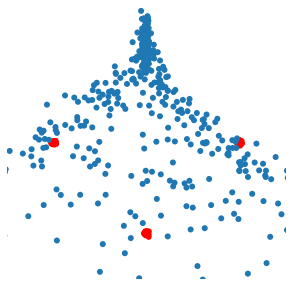

 33%|███▎      | 501/1500 [00:48<02:42,  6.16it/s]

reject


 33%|███▎      | 502/1500 [00:49<03:34,  4.66it/s]

[[0.95594764], [0.9887746]]
accept
[[0.9887746], [0.9710472]]
accept
[[0.9710472], [0.96472853]]
reject


 34%|███▎      | 506/1500 [00:49<03:00,  5.51it/s]

[[0.9480255], [0.9662502]]
accept
[[0.9662502], [0.9595643]]
reject


 34%|███▍      | 508/1500 [00:49<02:57,  5.59it/s]

[[0.9595643], [0.96480167]]
reject


 34%|███▍      | 510/1500 [00:50<02:54,  5.67it/s]

[[0.91449594], [0.9484892]]
accept
[[0.9484892], [0.94427365]]
accept
[[0.94427365], [0.9328575]]
reject


 34%|███▍      | 514/1500 [00:50<02:30,  6.54it/s]

[[0.9482986], [0.97861403]]
accept
[[0.97861403], [0.94166625]]
accept
[[0.94166625], [0.93868995]]
reject


 35%|███▍      | 518/1500 [00:51<02:13,  7.33it/s]

[[0.9311762], [0.9455478]]
accept
[[0.9455478], [0.93988305]]
reject


 35%|███▍      | 520/1500 [00:51<02:26,  6.68it/s]

[[0.93988305], [0.95883]]
reject


 35%|███▍      | 522/1500 [00:51<02:33,  6.37it/s]

[[0.9230945], [0.9617834]]
accept
[[0.9617834], [0.9219839]]
reject


 35%|███▍      | 524/1500 [00:52<02:39,  6.11it/s]

[[0.9219839], [0.95706236]]
accept
[[0.91258717], [0.8995726]]
reject


 35%|███▌      | 527/1500 [00:52<02:28,  6.56it/s]

[[0.8995726], [0.9619888]]
accept
[[0.9619888], [0.9356742]]
accept
[[0.9630711], [0.9478967]]
reject


 35%|███▌      | 531/1500 [00:52<02:13,  7.28it/s]

[[0.9478967], [0.9830704]]
accept
[[0.9830704], [0.96499693]]
reject


 36%|███▌      | 534/1500 [00:53<02:09,  7.45it/s]

[[0.93201435], [0.9517606]]
accept
[[0.9517606], [0.9332876]]
reject


 36%|███▌      | 536/1500 [00:53<02:22,  6.78it/s]

[[0.9332876], [0.9388037]]
reject


 36%|███▌      | 538/1500 [00:54<02:31,  6.34it/s]

[[0.90827054], [0.9299744]]
accept
[[0.9299744], [0.9293872]]
accept
[[0.9293872], [0.9211694]]
reject


 36%|███▌      | 542/1500 [00:54<02:14,  7.11it/s]

[[0.93184316], [0.9492339]]
accept
[[0.9492339], [0.9229276]]
reject


 36%|███▋      | 544/1500 [00:54<02:26,  6.54it/s]

[[0.9229276], [0.9576229]]
reject


 36%|███▋      | 546/1500 [00:55<02:34,  6.16it/s]

[[0.88655484], [0.9012437]]
reject


 36%|███▋      | 547/1500 [00:55<03:25,  4.65it/s]

[[0.9012437], [0.9210911]]
accept
[[0.9210911], [0.9033414]]
accept
[[0.9322455], [0.929007]]
reject


 37%|███▋      | 551/1500 [00:55<02:51,  5.54it/s]

[[0.929007], [0.9376297]]
accept
[[0.9376297], [0.91295636]]
accept
[[0.9649706], [0.91293424]]
reject


 37%|███▋      | 555/1500 [00:56<02:27,  6.39it/s]

[[0.91293424], [0.9196244]]
accept
[[0.9196244], [0.9074735]]
reject


 37%|███▋      | 558/1500 [00:56<02:20,  6.69it/s]

[[0.94003963], [0.94124866]]
reject


 37%|███▋      | 559/1500 [00:57<03:17,  4.77it/s]

[[0.94124866], [0.95548373]]
accept
[[0.95548373], [0.91709197]]
reject


 37%|███▋      | 562/1500 [00:57<02:54,  5.38it/s]

[[0.9412072], [0.9479188]]
accept
[[0.9479188], [0.91648245]]
reject


 38%|███▊      | 564/1500 [00:57<02:55,  5.33it/s]

[[0.91648245], [0.93333524]]
reject


 38%|███▊      | 566/1500 [00:58<02:57,  5.28it/s]

[[0.9208158], [0.9386824]]
accept
[[0.9386824], [0.8972901]]
reject


 38%|███▊      | 568/1500 [00:58<02:56,  5.29it/s]

[[0.8972901], [0.9059731]]
accept
[[0.9316472], [0.9061514]]
reject


 38%|███▊      | 571/1500 [00:59<02:40,  5.79it/s]

[[0.9061514], [0.93172807]]
accept
[[0.93172807], [0.85712254]]
reject


 38%|███▊      | 574/1500 [00:59<02:27,  6.26it/s]

[[0.88836735], [0.9242726]]
accept
[[0.9242726], [0.91968036]]
reject


 38%|███▊      | 576/1500 [00:59<02:36,  5.92it/s]

[[0.91968036], [0.9476565]]
reject


 39%|███▊      | 578/1500 [01:00<02:41,  5.71it/s]

[[0.90851223], [0.91783094]]
accept
[[0.91783094], [0.908943]]
reject


 39%|███▊      | 580/1500 [01:00<02:43,  5.64it/s]

[[0.908943], [0.91460943]]
accept
[[0.8591157], [0.85724175]]
reject


 39%|███▉      | 583/1500 [01:00<02:29,  6.13it/s]

[[0.85724175], [0.88632417]]
reject


 39%|███▉      | 584/1500 [01:01<03:22,  4.52it/s]

[[0.88632417], [0.90733415]]
reject


 39%|███▉      | 586/1500 [01:01<03:14,  4.70it/s]

[[0.90711474], [0.9137265]]
accept
[[0.9137265], [0.88001317]]
reject


 39%|███▉      | 588/1500 [01:02<03:06,  4.88it/s]

[[0.88001317], [0.8971233]]
reject


 39%|███▉      | 590/1500 [01:02<03:01,  5.00it/s]

[[0.87079126], [0.9404131]]
accept
[[0.9404131], [0.8282722]]
reject


 39%|███▉      | 592/1500 [01:02<03:02,  4.99it/s]

[[0.8282722], [0.8610023]]
accept
[[0.90907955], [0.8942046]]
reject


 40%|███▉      | 595/1500 [01:03<02:44,  5.51it/s]

[[0.8942046], [0.91009164]]
accept
[[0.91009164], [0.84538215]]
reject


 40%|███▉      | 598/1500 [01:03<02:31,  5.94it/s]

[[0.8741275], [0.9038415]]
accept
[[0.9038415], [0.8861934]]
accept
[[0.8861934], [0.8784025]]
[0.8574957]


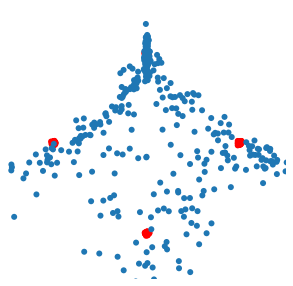

 40%|████      | 601/1500 [01:03<02:14,  6.70it/s]

reject


 40%|████      | 602/1500 [01:04<03:18,  4.53it/s]

[[0.8574957], [0.8858225]]
reject


 40%|████      | 603/1500 [01:04<03:57,  3.77it/s]

[[0.8858225], [0.8919253]]
accept
[[0.8919253], [0.83627313]]
accept
[[0.8947534], [0.8833891]]
reject


 40%|████      | 607/1500 [01:05<03:15,  4.58it/s]

[[0.8833891], [0.8956723]]
accept
[[0.8956723], [0.8865528]]
reject


 41%|████      | 610/1500 [01:05<02:55,  5.08it/s]

[[0.8799415], [0.9071257]]
accept
[[0.9071257], [0.8834426]]
reject


 41%|████      | 612/1500 [01:06<03:00,  4.91it/s]

[[0.8834426], [0.89589703]]
accept
[[0.89593995], [0.8895122]]
reject


 41%|████      | 615/1500 [01:06<02:44,  5.39it/s]

[[0.8895122], [0.9080352]]
accept
[[0.9080352], [0.8975343]]
reject


 41%|████      | 618/1500 [01:06<02:31,  5.82it/s]

[[0.8543794], [0.8790548]]
reject


 41%|████▏     | 619/1500 [01:07<03:27,  4.26it/s]

[[0.8790548], [0.884163]]
accept
[[0.884163], [0.8446152]]
accept
[[0.918219], [0.8374852]]
reject


 42%|████▏     | 623/1500 [01:07<02:53,  5.04it/s]

[[0.8374852], [0.8841084]]
accept
[[0.8841084], [0.8594582]]
accept
[[0.8803473], [0.8801739]]
reject


 42%|████▏     | 627/1500 [01:08<02:29,  5.84it/s]

[[0.8801739], [0.8978819]]
accept
[[0.8978819], [0.8859874]]
accept
[[0.8874859], [0.88314575]]
accept
[[0.88314575], [0.85474074]]
reject


 42%|████▏     | 632/1500 [01:08<02:07,  6.81it/s]

[[0.85474074], [0.8923614]]
reject


 42%|████▏     | 634/1500 [01:09<02:21,  6.12it/s]

[[0.85090876], [0.86887825]]
reject


 42%|████▏     | 635/1500 [01:09<03:17,  4.39it/s]

[[0.86887825], [0.89961195]]
accept
[[0.89961195], [0.83750415]]
accept
[[0.91207063], [0.88877755]]
reject


 43%|████▎     | 639/1500 [01:09<02:46,  5.16it/s]

[[0.88877755], [0.9254239]]
accept
[[0.9254239], [0.84332925]]
accept
[[0.87122124], [0.84870535]]
reject


 43%|████▎     | 643/1500 [01:10<02:24,  5.93it/s]

[[0.84870535], [0.85643435]]
reject


 43%|████▎     | 644/1500 [01:10<03:14,  4.40it/s]

[[0.85643435], [0.9117581]]
reject


 43%|████▎     | 646/1500 [01:11<03:06,  4.58it/s]

[[0.88125896], [0.8835448]]
reject


 43%|████▎     | 647/1500 [01:11<03:52,  3.67it/s]

[[0.8835448], [0.8875193]]
accept
[[0.8875193], [0.852767]]
accept
[[0.88960725], [0.8841641]]
reject


 43%|████▎     | 651/1500 [01:11<03:11,  4.44it/s]

[[0.8841641], [0.8929337]]
accept
[[0.8929337], [0.80640423]]
reject


 44%|████▎     | 654/1500 [01:12<02:50,  4.96it/s]

[[0.83122545], [0.8607041]]
reject


 44%|████▎     | 655/1500 [01:12<03:36,  3.91it/s]

[[0.8607041], [0.92662007]]
accept
[[0.92662007], [0.87061095]]
reject


 44%|████▍     | 658/1500 [01:13<03:07,  4.49it/s]

[[0.8452381], [0.889939]]
reject


 44%|████▍     | 659/1500 [01:13<03:47,  3.70it/s]

[[0.889939], [0.8916536]]
accept
[[0.8916536], [0.8492354]]
reject


 44%|████▍     | 662/1500 [01:14<03:16,  4.27it/s]

[[0.82643265], [0.8869045]]
accept
[[0.8869045], [0.86574876]]
accept
[[0.86574876], [0.8417149]]
accept
[[0.936831], [0.8726431]]
reject


 44%|████▍     | 667/1500 [01:14<02:40,  5.19it/s]

[[0.8726431], [0.883391]]
reject


 45%|████▍     | 668/1500 [01:14<03:31,  3.94it/s]

[[0.883391], [0.8904983]]
reject


 45%|████▍     | 670/1500 [01:15<03:20,  4.14it/s]

[[0.81860876], [0.86461115]]
reject


 45%|████▍     | 671/1500 [01:15<04:01,  3.43it/s]

[[0.86461115], [0.89509046]]
accept
[[0.89509046], [0.8665941]]
accept
[[0.86792076], [0.8544501]]
reject


 45%|████▌     | 675/1500 [01:16<03:16,  4.21it/s]

[[0.8544501], [0.8825832]]
accept
[[0.8825832], [0.7828355]]
accept
[[0.89150417], [0.82144976]]
reject


 45%|████▌     | 679/1500 [01:16<02:44,  4.99it/s]

[[0.82144976], [0.90958786]]
accept
[[0.90958786], [0.84785616]]
accept
[[0.85623753], [0.83363974]]
reject


 46%|████▌     | 683/1500 [01:17<02:23,  5.71it/s]

[[0.83363974], [0.86047477]]
accept
[[0.86047477], [0.84262407]]
reject


 46%|████▌     | 686/1500 [01:17<02:15,  6.03it/s]

[[0.8225484], [0.89028406]]
accept
[[0.89028406], [0.85606897]]
reject


 46%|████▌     | 688/1500 [01:17<02:25,  5.59it/s]

[[0.85606897], [0.8604926]]
reject


 46%|████▌     | 690/1500 [01:18<02:33,  5.29it/s]

[[0.8583361], [0.9021646]]
accept
[[0.9021646], [0.8511217]]
accept
[[0.8511217], [0.8068724]]
accept
[[0.85758185], [0.85327625]]
reject


 46%|████▋     | 695/1500 [01:18<02:10,  6.19it/s]

[[0.85327625], [0.884585]]
accept
[[0.884585], [0.85365856]]
reject


 47%|████▋     | 698/1500 [01:19<02:07,  6.27it/s]

[[0.8389752], [0.858698]]
accept
[[0.858698], [0.8528]]
accept
[[0.8528], [0.8244997]]
[0.86872876]


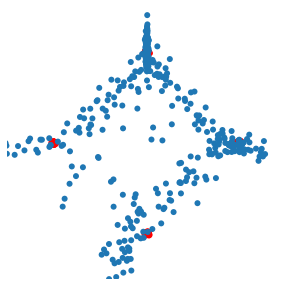

 47%|████▋     | 701/1500 [01:19<01:54,  7.00it/s]

accept
[[0.86872876], [0.83214414]]
reject


 47%|████▋     | 703/1500 [01:20<02:13,  5.95it/s]

[[0.83214414], [0.8347144]]
accept
[[0.8347144], [0.81267977]]
reject


 47%|████▋     | 706/1500 [01:20<02:12,  6.00it/s]

[[0.807762], [0.8594754]]
accept
[[0.8594754], [0.8527007]]
accept
[[0.8527007], [0.8504008]]
reject


 47%|████▋     | 710/1500 [01:21<02:00,  6.56it/s]

[[0.8805921], [0.88853455]]
accept
[[0.88853455], [0.8799437]]
accept
[[0.8799437], [0.8460866]]
accept
[[0.88254714], [0.8289683]]
reject


 48%|████▊     | 715/1500 [01:21<01:47,  7.29it/s]

[[0.8289683], [0.8540664]]
accept
[[0.8540664], [0.7594769]]
reject


 48%|████▊     | 718/1500 [01:22<01:50,  7.06it/s]

[[0.8229641], [0.8484255]]
reject


 48%|████▊     | 719/1500 [01:22<02:56,  4.43it/s]

[[0.8484255], [0.84996426]]
accept
[[0.84996426], [0.79319555]]
reject


 48%|████▊     | 722/1500 [01:22<02:38,  4.90it/s]

[[0.78297246], [0.8351297]]
reject


 48%|████▊     | 723/1500 [01:23<03:30,  3.69it/s]

[[0.8351297], [0.8386547]]
accept
[[0.8386547], [0.8325428]]
reject


 48%|████▊     | 726/1500 [01:23<03:03,  4.22it/s]

[[0.7798577], [0.79165673]]
reject


 48%|████▊     | 727/1500 [01:24<03:54,  3.30it/s]

[[0.79165673], [0.8299303]]
accept
[[0.8299303], [0.8068292]]
reject


 49%|████▊     | 730/1500 [01:24<03:23,  3.79it/s]

[[0.7930055], [0.8693925]]
accept
[[0.8693925], [0.85516757]]
accept
[[0.85516757], [0.84641397]]
accept
[[0.86780065], [0.86314654]]
reject


 49%|████▉     | 735/1500 [01:25<02:47,  4.58it/s]

[[0.86314654], [0.8791772]]
accept
[[0.8791772], [0.8565491]]
accept
[[0.8913426], [0.8694098]]
accept
[[0.8694098], [0.83889014]]
reject


 49%|████▉     | 740/1500 [01:25<02:19,  5.46it/s]

[[0.83889014], [0.91057813]]
accept
[[0.8372835], [0.81021416]]
reject


 50%|████▉     | 743/1500 [01:26<02:13,  5.66it/s]

[[0.81021416], [0.8525233]]
accept
[[0.8525233], [0.78185844]]
reject


 50%|████▉     | 746/1500 [01:26<02:10,  5.78it/s]

[[0.82000923], [0.87019277]]
accept
[[0.87019277], [0.84532106]]
reject


 50%|████▉     | 748/1500 [01:27<02:21,  5.31it/s]

[[0.84532106], [0.8649967]]
reject


 50%|█████     | 750/1500 [01:27<02:27,  5.08it/s]

[[0.8443171], [0.88776594]]
accept
[[0.88776594], [0.7888682]]
reject


 50%|█████     | 752/1500 [01:28<02:32,  4.91it/s]

[[0.7888682], [0.8750546]]
reject


 50%|█████     | 754/1500 [01:28<02:35,  4.79it/s]

[[0.7602069], [0.8188957]]
reject


 50%|█████     | 755/1500 [01:29<03:25,  3.62it/s]

[[0.8188957], [0.8774061]]
accept
[[0.8774061], [0.84035003]]
accept
[[0.82220906], [0.80683696]]
reject


 51%|█████     | 759/1500 [01:29<02:50,  4.35it/s]

[[0.80683696], [0.8250909]]
reject


 51%|█████     | 760/1500 [01:29<03:33,  3.46it/s]

[[0.8250909], [0.8391728]]
reject


 51%|█████     | 762/1500 [01:30<03:19,  3.69it/s]

[[0.86296487], [0.8649034]]
accept
[[0.8649034], [0.82511693]]
reject


 51%|█████     | 764/1500 [01:30<03:10,  3.87it/s]

[[0.82511693], [0.83217883]]
reject


 51%|█████     | 766/1500 [01:31<03:04,  3.98it/s]

[[0.78130347], [0.84908366]]
accept
[[0.84908366], [0.7988533]]
reject


 51%|█████     | 768/1500 [01:31<02:57,  4.12it/s]

[[0.7988533], [0.8073897]]
reject


 51%|█████▏    | 770/1500 [01:32<02:55,  4.17it/s]

[[0.84884053], [0.8748528]]
accept
[[0.8748528], [0.75666547]]
reject


 51%|█████▏    | 772/1500 [01:32<02:51,  4.24it/s]

[[0.75666547], [0.8208982]]
reject


 52%|█████▏    | 774/1500 [01:33<02:48,  4.31it/s]

[[0.8250358], [0.8288647]]
accept
[[0.8288647], [0.7877381]]
reject


 52%|█████▏    | 776/1500 [01:33<02:46,  4.34it/s]

[[0.7877381], [0.8455988]]
accept
[[0.88470227], [0.85276115]]
reject


 52%|█████▏    | 779/1500 [01:34<02:32,  4.73it/s]

[[0.85276115], [0.8688352]]
accept
[[0.8688352], [0.8282385]]
reject


 52%|█████▏    | 782/1500 [01:34<02:20,  5.11it/s]

[[0.8408439], [0.8524051]]
accept
[[0.8524051], [0.76591676]]
reject


 52%|█████▏    | 784/1500 [01:35<02:29,  4.78it/s]

[[0.76591676], [0.76874876]]
accept
[[0.8431229], [0.78412175]]
reject


 52%|█████▏    | 787/1500 [01:35<02:19,  5.11it/s]

[[0.78412175], [0.9127175]]
accept
[[0.9127175], [0.84508735]]
reject


 53%|█████▎    | 790/1500 [01:36<02:11,  5.40it/s]

[[0.8143636], [0.83106667]]
accept
[[0.83106667], [0.82939744]]
accept
[[0.82939744], [0.81851846]]
accept
[[0.84455514], [0.82958835]]
reject


 53%|█████▎    | 795/1500 [01:36<01:56,  6.04it/s]

[[0.82958835], [0.83888435]]
accept
[[0.83888435], [0.7222657]]
reject


 53%|█████▎    | 798/1500 [01:37<01:57,  5.96it/s]

[[0.7662508], [0.8662639]]
reject


 53%|█████▎    | 799/1500 [01:37<03:00,  3.89it/s]

[[0.8662639], [0.88040733]]
accept
[[0.88040733], [0.7951822]]
[0.8323736]


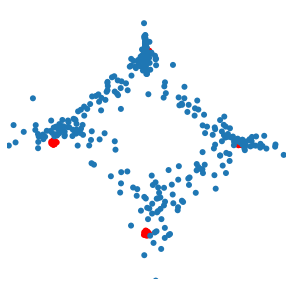

 53%|█████▎    | 801/1500 [01:37<02:36,  4.46it/s]

reject


 53%|█████▎    | 802/1500 [01:38<03:24,  3.41it/s]

[[0.8323736], [0.83974504]]
accept
[[0.83974504], [0.8021165]]
reject


 54%|█████▎    | 804/1500 [01:38<03:12,  3.62it/s]

[[0.8021165], [0.8156615]]
reject


 54%|█████▎    | 806/1500 [01:39<03:05,  3.73it/s]

[[0.83809346], [0.8390963]]
accept
[[0.8390963], [0.8306593]]
reject


 54%|█████▍    | 808/1500 [01:39<03:01,  3.81it/s]

[[0.8306593], [0.8496231]]
accept
[[0.8441217], [0.8373651]]
reject


 54%|█████▍    | 811/1500 [01:40<02:41,  4.27it/s]

[[0.8373651], [0.8379456]]
accept
[[0.8379456], [0.834092]]
accept
[[0.88698983], [0.82137597]]
reject


 54%|█████▍    | 815/1500 [01:40<02:18,  4.93it/s]

[[0.82137597], [0.86691856]]
accept
[[0.86691856], [0.8063545]]
accept
[[0.8449423], [0.8425443]]
accept
[[0.8425443], [0.830828]]
reject


 55%|█████▍    | 820/1500 [01:41<01:58,  5.73it/s]

[[0.830828], [0.83878875]]
accept
[[0.80634576], [0.77630246]]
reject


 55%|█████▍    | 823/1500 [01:41<01:57,  5.76it/s]

[[0.77630246], [0.8164045]]
accept
[[0.8164045], [0.7959417]]
reject


 55%|█████▌    | 826/1500 [01:42<01:55,  5.85it/s]

[[0.80709445], [0.8409587]]
accept
[[0.8409587], [0.797632]]
reject


 55%|█████▌    | 828/1500 [01:42<02:08,  5.24it/s]

[[0.797632], [0.808353]]
reject


 55%|█████▌    | 830/1500 [01:43<02:17,  4.86it/s]

[[0.8083312], [0.88111895]]
accept
[[0.88111895], [0.76755553]]
reject


 55%|█████▌    | 832/1500 [01:43<02:26,  4.56it/s]

[[0.76755553], [0.77298343]]
reject


 56%|█████▌    | 834/1500 [01:44<02:29,  4.45it/s]

[[0.86053556], [0.86827064]]
accept
[[0.86827064], [0.7906215]]
reject


 56%|█████▌    | 836/1500 [01:44<02:31,  4.38it/s]

[[0.7906215], [0.85049546]]
reject


 56%|█████▌    | 838/1500 [01:45<02:32,  4.34it/s]

[[0.7779546], [0.8534486]]
accept
[[0.8534486], [0.8275939]]
reject


 56%|█████▌    | 840/1500 [01:45<02:33,  4.31it/s]

[[0.8275939], [0.8529056]]
reject


 56%|█████▌    | 842/1500 [01:46<02:34,  4.26it/s]

[[0.8085885], [0.8464478]]
accept
[[0.8464478], [0.7042727]]
reject


 56%|█████▋    | 844/1500 [01:46<02:34,  4.25it/s]

[[0.7042727], [0.72530234]]
accept
[[0.7768495], [0.77132106]]
reject


 56%|█████▋    | 847/1500 [01:47<02:20,  4.65it/s]

[[0.77132106], [0.83480525]]
reject


 57%|█████▋    | 848/1500 [01:47<03:08,  3.45it/s]

[[0.83480525], [0.84689415]]
accept
[[0.7333802], [0.71214455]]
reject


 57%|█████▋    | 851/1500 [01:48<02:43,  3.96it/s]

[[0.71214455], [0.82399297]]
accept
[[0.82399297], [0.8061255]]
reject


 57%|█████▋    | 854/1500 [01:48<02:26,  4.41it/s]

[[0.83640474], [0.8628817]]
accept
[[0.8628817], [0.7764337]]
reject


 57%|█████▋    | 856/1500 [01:49<02:28,  4.34it/s]

[[0.7764337], [0.8436524]]
reject


 57%|█████▋    | 858/1500 [01:49<02:33,  4.18it/s]

[[0.8172319], [0.84583515]]
accept
[[0.84583515], [0.7889473]]
reject


 57%|█████▋    | 860/1500 [01:50<02:37,  4.05it/s]

[[0.7889473], [0.83291316]]
reject


 57%|█████▋    | 862/1500 [01:50<02:37,  4.04it/s]

[[0.771362], [0.8057294]]
accept
[[0.8057294], [0.79853034]]
reject


 58%|█████▊    | 864/1500 [01:51<02:37,  4.03it/s]

[[0.79853034], [0.85441566]]
accept
[[0.82671046], [0.81874055]]
reject


 58%|█████▊    | 867/1500 [01:51<02:24,  4.39it/s]

[[0.81874055], [0.83797574]]
accept
[[0.83797574], [0.8115611]]
accept
[[0.8882495], [0.8152232]]
reject


 58%|█████▊    | 871/1500 [01:52<02:06,  4.96it/s]

[[0.8152232], [0.85080737]]
accept
[[0.85080737], [0.75025666]]
accept
[[0.84610385], [0.7858184]]
reject


 58%|█████▊    | 875/1500 [01:52<01:55,  5.42it/s]

[[0.7858184], [0.8414291]]
accept
[[0.8414291], [0.7732345]]
reject


 59%|█████▊    | 878/1500 [01:53<01:53,  5.47it/s]

[[0.78291583], [0.81520265]]
accept
[[0.81520265], [0.7952604]]
reject


 59%|█████▊    | 880/1500 [01:53<02:07,  4.85it/s]

[[0.7952604], [0.82630515]]
reject


 59%|█████▉    | 882/1500 [01:54<02:17,  4.49it/s]

[[0.77818257], [0.8023947]]
reject


 59%|█████▉    | 883/1500 [01:54<03:11,  3.22it/s]

[[0.8023947], [0.8139204]]
reject


 59%|█████▉    | 884/1500 [01:55<03:47,  2.71it/s]

[[0.8139204], [0.8189457]]
reject


 59%|█████▉    | 886/1500 [01:55<03:24,  3.00it/s]

[[0.79322463], [0.8145596]]
accept
[[0.8145596], [0.7821607]]
reject


 59%|█████▉    | 888/1500 [01:56<03:09,  3.23it/s]

[[0.7821607], [0.829893]]
reject


 59%|█████▉    | 890/1500 [01:56<02:58,  3.42it/s]

[[0.7833903], [0.81469]]
accept
[[0.81469], [0.791955]]
reject


 59%|█████▉    | 892/1500 [01:57<02:50,  3.57it/s]

[[0.791955], [0.838536]]
accept
[[0.8085844], [0.7789463]]
reject


 60%|█████▉    | 895/1500 [01:58<02:30,  4.01it/s]

[[0.7789463], [0.85380137]]
accept
[[0.85380137], [0.78868014]]
accept
[[0.8596983], [0.8012352]]
reject


 60%|█████▉    | 899/1500 [01:58<02:09,  4.63it/s]

[[0.8012352], [0.8206237]]
reject


 60%|██████    | 900/1500 [01:59<02:58,  3.36it/s]

[[0.8206237], [0.83562183]]
[0.7689246]


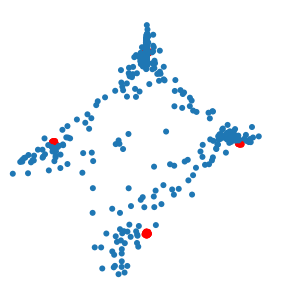

 60%|██████    | 901/1500 [01:59<02:53,  3.45it/s]

accept
[[0.7689246], [0.7556933]]
reject


 60%|██████    | 903/1500 [01:59<02:47,  3.55it/s]

[[0.7556933], [0.8443537]]
accept
[[0.8443537], [0.8019015]]
reject


 60%|██████    | 906/1500 [02:00<02:28,  4.01it/s]

[[0.74907815], [0.79839814]]
reject


 60%|██████    | 907/1500 [02:00<03:10,  3.11it/s]

[[0.79839814], [0.80483234]]
reject


 61%|██████    | 908/1500 [02:01<03:39,  2.70it/s]

[[0.80483234], [0.8084871]]
accept
[[0.80856407], [0.7727641]]
reject


 61%|██████    | 911/1500 [02:01<03:04,  3.19it/s]

[[0.7727641], [0.8211037]]
reject


 61%|██████    | 912/1500 [02:02<03:36,  2.71it/s]

[[0.8211037], [0.84146297]]
reject


 61%|██████    | 914/1500 [02:02<03:18,  2.96it/s]

[[0.7737145], [0.84164774]]
accept
[[0.84164774], [0.8259527]]
accept
[[0.8259527], [0.8236792]]
accept
[[0.8090864], [0.77357656]]
reject


 61%|██████▏   | 919/1500 [02:03<02:38,  3.68it/s]

[[0.77357656], [0.7754747]]
accept
[[0.7754747], [0.75402206]]
reject


 61%|██████▏   | 922/1500 [02:04<02:21,  4.08it/s]

[[0.8089479], [0.8318044]]
accept
[[0.8318044], [0.8203416]]
accept
[[0.8203416], [0.80015665]]
accept
[[0.8607161], [0.81904995]]
reject


 62%|██████▏   | 927/1500 [02:04<01:58,  4.84it/s]

[[0.81904995], [0.8720372]]
accept
[[0.8720372], [0.7961005]]
accept
[[0.87747145], [0.81768215]]
reject


 62%|██████▏   | 931/1500 [02:05<01:46,  5.36it/s]

[[0.81768215], [0.85056823]]
accept
[[0.85056823], [0.82734424]]
reject


 62%|██████▏   | 934/1500 [02:05<01:45,  5.35it/s]

[[0.787151], [0.81961983]]
accept
[[0.81961983], [0.7528516]]
accept
[[0.7528516], [0.7521953]]
reject


 63%|██████▎   | 938/1500 [02:06<01:39,  5.66it/s]

[[0.78621876], [0.83796155]]
accept
[[0.83796155], [0.83153176]]
accept
[[0.83153176], [0.8198124]]
reject


 63%|██████▎   | 942/1500 [02:07<01:41,  5.50it/s]

[[0.7973045], [0.82930124]]
accept
[[0.82930124], [0.7519964]]
reject


 63%|██████▎   | 944/1500 [02:07<01:55,  4.81it/s]

[[0.7519964], [0.75794864]]
reject


 63%|██████▎   | 946/1500 [02:08<02:04,  4.46it/s]

[[0.73830056], [0.77685064]]
reject


 63%|██████▎   | 947/1500 [02:08<02:51,  3.23it/s]

[[0.77685064], [0.7930232]]
reject


 63%|██████▎   | 948/1500 [02:09<03:26,  2.68it/s]

[[0.7930232], [0.85342157]]
accept
[[0.81635356], [0.7900049]]
reject


 63%|██████▎   | 951/1500 [02:09<02:55,  3.13it/s]

[[0.7900049], [0.8266247]]
accept
[[0.8266247], [0.739221]]
reject


 64%|██████▎   | 954/1500 [02:10<02:32,  3.57it/s]

[[0.7277285], [0.77578586]]
accept
[[0.77578586], [0.7732669]]
reject


 64%|██████▎   | 956/1500 [02:10<02:32,  3.57it/s]

[[0.7732669], [0.8503196]]
accept
[[0.8234194], [0.81737417]]
reject


 64%|██████▍   | 959/1500 [02:11<02:16,  3.96it/s]

[[0.81737417], [0.83155966]]
accept
[[0.83155966], [0.78890544]]
accept
[[0.80214924], [0.76082677]]
reject


 64%|██████▍   | 963/1500 [02:12<01:58,  4.52it/s]

[[0.76082677], [0.80547404]]
accept
[[0.80547404], [0.7909018]]
accept
[[0.7146956], [0.6906563]]
reject


 64%|██████▍   | 967/1500 [02:12<01:45,  5.05it/s]

[[0.6906563], [0.7257673]]
accept
[[0.7257673], [0.7179495]]
reject


 65%|██████▍   | 970/1500 [02:13<01:44,  5.09it/s]

[[0.63879955], [0.6401675]]
reject


 65%|██████▍   | 971/1500 [02:13<02:37,  3.36it/s]

[[0.6401675], [0.6667922]]
accept
[[0.6667922], [0.6537498]]
reject


 65%|██████▍   | 974/1500 [02:14<02:20,  3.74it/s]

[[0.7506218], [0.75468373]]
accept
[[0.75468373], [0.72516894]]
accept
[[0.72516894], [0.72277004]]
reject


 66%|██████▌   | 983/1500 [02:15<01:26,  5.95it/s]

[[0.7935426], [0.8458594]]
accept
[[0.8458594], [0.82886404]]
accept
[[0.82886404], [0.81798327]]
accept
[[0.8369811], [0.8247861]]
accept
[[0.8247861], [0.7884176]]
accept
[[0.7884176], [0.76283646]]
reject


 66%|██████▌   | 986/1500 [02:15<01:29,  5.74it/s]

[[0.8014765], [0.8378961]]
accept
[[0.8378961], [0.76843226]]
reject


 66%|██████▌   | 988/1500 [02:16<01:44,  4.91it/s]

[[0.76843226], [0.81336]]
reject


 66%|██████▌   | 990/1500 [02:16<01:54,  4.44it/s]

[[0.77850175], [0.77995205]]
accept
[[0.77995205], [0.77047765]]
reject


 66%|██████▌   | 992/1500 [02:17<02:02,  4.14it/s]

[[0.77047765], [0.79269254]]
reject


 66%|██████▋   | 994/1500 [02:17<02:08,  3.94it/s]

[[0.78780955], [0.8300051]]
accept
[[0.8300051], [0.6473264]]
reject


 66%|██████▋   | 996/1500 [02:18<02:12,  3.80it/s]

[[0.6473264], [0.7296251]]
reject


 67%|██████▋   | 998/1500 [02:18<02:13,  3.75it/s]

[[0.77364004], [0.81527597]]
accept
[[0.81527597], [0.787047]]
accept
[[0.787047], [0.76501983]]
[0.7938955]


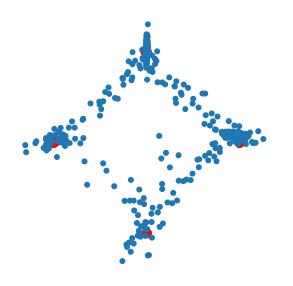

 67%|██████▋   | 1001/1500 [02:19<01:48,  4.58it/s]

reject


 67%|██████▋   | 1002/1500 [02:19<02:42,  3.07it/s]

[[0.7938955], [0.81390715]]
accept
[[0.81390715], [0.75068235]]
reject


 67%|██████▋   | 1004/1500 [02:20<02:35,  3.18it/s]

[[0.75068235], [0.7826624]]
accept
[[0.78761506], [0.7557702]]
reject


 67%|██████▋   | 1007/1500 [02:21<02:16,  3.61it/s]

[[0.7557702], [0.8366866]]
accept
[[0.8366866], [0.7889079]]
reject


 67%|██████▋   | 1010/1500 [02:21<02:04,  3.95it/s]

[[0.74141], [0.79293656]]
accept
[[0.79293656], [0.7739538]]
accept
[[0.7739538], [0.73725617]]
reject


 68%|██████▊   | 1014/1500 [02:22<01:48,  4.47it/s]

[[0.7427292], [0.8239994]]
accept
[[0.8239994], [0.75882506]]
reject


 68%|██████▊   | 1016/1500 [02:22<01:56,  4.14it/s]

[[0.75882506], [0.8249805]]
reject


 68%|██████▊   | 1018/1500 [02:23<02:04,  3.87it/s]

[[0.6804924], [0.73303616]]
reject


 68%|██████▊   | 1019/1500 [02:23<02:50,  2.83it/s]

[[0.73303616], [0.7720101]]
accept
[[0.7720101], [0.72091174]]
accept
[[0.8142179], [0.7951717]]
reject


 68%|██████▊   | 1023/1500 [02:24<02:23,  3.32it/s]

[[0.7951717], [0.8269824]]
accept
[[0.8269824], [0.75018317]]
reject


 68%|██████▊   | 1026/1500 [02:25<02:11,  3.60it/s]

[[0.80244124], [0.8078624]]
accept
[[0.8078624], [0.7897644]]
reject


 69%|██████▊   | 1028/1500 [02:25<02:13,  3.53it/s]

[[0.7897644], [0.8261694]]
accept
[[0.83628273], [0.72368777]]
reject


 69%|██████▊   | 1031/1500 [02:26<02:00,  3.89it/s]

[[0.72368777], [0.81121594]]
accept
[[0.81121594], [0.7052767]]
accept
[[0.76086724], [0.7357439]]
reject


 69%|██████▉   | 1035/1500 [02:27<01:45,  4.41it/s]

[[0.7357439], [0.7675568]]
accept
[[0.7675568], [0.74542]]
reject


 69%|██████▉   | 1038/1500 [02:27<01:40,  4.58it/s]

[[0.7964293], [0.8435793]]
accept
[[0.8435793], [0.79996556]]
accept
[[0.79996556], [0.7876371]]
reject


 69%|██████▉   | 1042/1500 [02:28<01:31,  5.01it/s]

[[0.763078], [0.8311577]]
accept
[[0.8311577], [0.8217903]]
accept
[[0.8217903], [0.7707125]]
accept
[[0.81240803], [0.7041595]]
reject


 70%|██████▉   | 1047/1500 [02:29<01:21,  5.55it/s]

[[0.7041595], [0.81457585]]
accept
[[0.81457585], [0.7133016]]
reject


 70%|███████   | 1050/1500 [02:29<01:23,  5.37it/s]

[[0.7917949], [0.79455364]]
reject


 70%|███████   | 1051/1500 [02:30<02:14,  3.34it/s]

[[0.79455364], [0.7955632]]
accept
[[0.7955632], [0.72570264]]
reject


 70%|███████   | 1054/1500 [02:30<02:01,  3.67it/s]

[[0.79763806], [0.81786263]]
reject


 70%|███████   | 1055/1500 [02:31<02:39,  2.79it/s]

[[0.81786263], [0.8232185]]
reject


 70%|███████   | 1056/1500 [02:31<03:05,  2.39it/s]

[[0.8232185], [0.8388079]]
reject


 71%|███████   | 1058/1500 [02:32<02:49,  2.61it/s]

[[0.7545347], [0.7725741]]
reject


 71%|███████   | 1059/1500 [02:33<03:12,  2.30it/s]

[[0.7725741], [0.8455114]]
accept
[[0.8455114], [0.81626785]]
accept
[[0.8201438], [0.78593683]]
reject


 71%|███████   | 1063/1500 [02:33<02:33,  2.84it/s]

[[0.78593683], [0.8366821]]
accept
[[0.8366821], [0.78766924]]
accept
[[0.8039701], [0.7200021]]
reject


 71%|███████   | 1067/1500 [02:34<02:08,  3.37it/s]

[[0.7200021], [0.76196027]]
accept
[[0.76196027], [0.65007854]]
reject


 71%|███████▏  | 1070/1500 [02:35<01:55,  3.72it/s]

[[0.6043457], [0.72102463]]
accept
[[0.72102463], [0.71584225]]
reject


 71%|███████▏  | 1072/1500 [02:35<02:00,  3.56it/s]

[[0.71584225], [0.7744893]]
reject


 72%|███████▏  | 1074/1500 [02:36<02:03,  3.45it/s]

[[0.76968646], [0.8157724]]
accept
[[0.8157724], [0.755165]]
reject


 72%|███████▏  | 1076/1500 [02:36<02:04,  3.42it/s]

[[0.755165], [0.75581527]]
accept
[[0.7154455], [0.71472]]
reject


 72%|███████▏  | 1079/1500 [02:37<01:52,  3.74it/s]

[[0.71472], [0.7471134]]
reject


 72%|███████▏  | 1080/1500 [02:38<02:33,  2.73it/s]

[[0.7471134], [0.8024281]]
reject


 72%|███████▏  | 1082/1500 [02:38<02:26,  2.85it/s]

[[0.7363587], [0.771778]]
accept
[[0.771778], [0.73708093]]
reject


 72%|███████▏  | 1084/1500 [02:39<02:19,  2.98it/s]

[[0.73708093], [0.74362063]]
reject


 73%|███████▎  | 1091/1500 [02:40<01:35,  4.28it/s]

[[0.69680715], [0.7812407]]
accept
[[0.7812407], [0.7649214]]
accept
[[0.7649214], [0.7602314]]
accept
[[0.7990569], [0.7767891]]
accept
[[0.7767891], [0.71641284]]
reject


 73%|███████▎  | 1093/1500 [02:40<01:43,  3.94it/s]

[[0.71641284], [0.75305283]]
accept
[[0.7849934], [0.77304107]]
accept
[[0.77304107], [0.7665322]]
reject


 73%|███████▎  | 1096/1500 [02:41<01:37,  4.13it/s]

[[0.7665322], [0.80732447]]
reject


 73%|███████▎  | 1098/1500 [02:41<01:44,  3.84it/s]

[[0.67358136], [0.7803469]]
reject


 73%|███████▎  | 1099/1500 [02:42<02:25,  2.75it/s]

[[0.7803469], [0.7939532]]
accept
[[0.7939532], [0.76382804]]
[0.78241396]


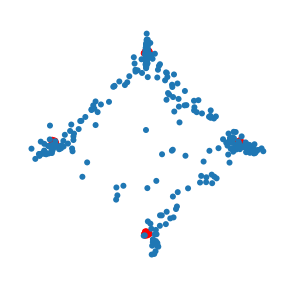

 73%|███████▎  | 1101/1500 [02:42<01:59,  3.35it/s]

reject


 73%|███████▎  | 1102/1500 [02:43<02:38,  2.51it/s]

[[0.78241396], [0.81753314]]
accept
[[0.81753314], [0.7035815]]
accept
[[0.7035815], [0.68370116]]
reject


 74%|███████▎  | 1106/1500 [02:44<02:09,  3.03it/s]

[[0.7288502], [0.7810707]]
reject


 74%|███████▍  | 1107/1500 [02:44<02:43,  2.41it/s]

[[0.7810707], [0.8250274]]
reject


 74%|███████▍  | 1108/1500 [02:45<03:08,  2.08it/s]

[[0.8250274], [0.8308121]]
reject


 74%|███████▍  | 1110/1500 [02:45<02:47,  2.33it/s]

[[0.7425096], [0.7556556]]
accept
[[0.7556556], [0.71044827]]
accept
[[0.71044827], [0.70194876]]
reject


 74%|███████▍  | 1114/1500 [02:46<02:16,  2.84it/s]

[[0.71977115], [0.7480682]]
reject


 74%|███████▍  | 1115/1500 [02:47<02:45,  2.33it/s]

[[0.7480682], [0.76186335]]
reject


 74%|███████▍  | 1116/1500 [02:47<03:03,  2.09it/s]

[[0.76186335], [0.77215505]]
accept
[[0.71883523], [0.6810779]]
reject


 75%|███████▍  | 1119/1500 [02:48<02:32,  2.50it/s]

[[0.6810779], [0.785346]]
accept
[[0.785346], [0.73615634]]
reject


 75%|███████▍  | 1122/1500 [02:49<02:09,  2.91it/s]

[[0.67230785], [0.7084874]]
reject


 75%|███████▍  | 1123/1500 [02:49<02:37,  2.39it/s]

[[0.7084874], [0.74706805]]
reject


 75%|███████▍  | 1124/1500 [02:50<03:02,  2.06it/s]

[[0.74706805], [0.8161089]]
accept
[[0.7997989], [0.715279]]
reject


 75%|███████▌  | 1127/1500 [02:50<02:30,  2.48it/s]

[[0.715279], [0.7417039]]
accept
[[0.7417039], [0.69096994]]
reject


 75%|███████▌  | 1130/1500 [02:51<02:08,  2.88it/s]

[[0.70212317], [0.706033]]
accept
[[0.706033], [0.6743681]]
reject


 75%|███████▌  | 1132/1500 [02:52<02:05,  2.93it/s]

[[0.6743681], [0.75171757]]
accept
[[0.70837235], [0.7056682]]
accept
[[0.7056682], [0.6962017]]
reject


 76%|███████▌  | 1136/1500 [02:53<01:46,  3.41it/s]

[[0.6962017], [0.7301936]]
accept
[[0.74108315], [0.72903633]]
accept
[[0.72903633], [0.7165262]]
reject


 76%|███████▌  | 1140/1500 [02:53<01:33,  3.84it/s]

[[0.7165262], [0.8192377]]
accept
[[0.7929084], [0.76567495]]
reject


 76%|███████▌  | 1143/1500 [02:54<01:29,  3.97it/s]

[[0.76567495], [0.817188]]
accept
[[0.817188], [0.75162864]]
reject


 76%|███████▋  | 1146/1500 [02:55<01:27,  4.05it/s]

[[0.784596], [0.83374524]]
accept
[[0.83374524], [0.7178368]]
reject


 77%|███████▋  | 1148/1500 [02:55<01:37,  3.62it/s]

[[0.7178368], [0.75054145]]
reject


 77%|███████▋  | 1150/1500 [02:56<01:43,  3.39it/s]

[[0.7419848], [0.7772266]]
accept
[[0.7772266], [0.7461094]]
reject


 77%|███████▋  | 1152/1500 [02:57<01:47,  3.23it/s]

[[0.7461094], [0.794144]]
reject


 77%|███████▋  | 1154/1500 [02:57<01:50,  3.14it/s]

[[0.67354864], [0.7552056]]
accept
[[0.7552056], [0.6886618]]
reject


 77%|███████▋  | 1156/1500 [02:58<01:51,  3.09it/s]

[[0.6886618], [0.76591104]]
reject


 77%|███████▋  | 1158/1500 [02:59<01:52,  3.03it/s]

[[0.71380913], [0.7409749]]
reject


 77%|███████▋  | 1159/1500 [02:59<02:28,  2.30it/s]

[[0.7409749], [0.77021796]]
reject


 77%|███████▋  | 1160/1500 [03:00<02:50,  1.99it/s]

[[0.77021796], [0.7748172]]
reject


 77%|███████▋  | 1162/1500 [03:01<02:32,  2.21it/s]

[[0.719371], [0.8063083]]
accept
[[0.8063083], [0.73566425]]
reject


 78%|███████▊  | 1164/1500 [03:01<02:20,  2.40it/s]

[[0.73566425], [0.8102998]]
reject


 78%|███████▊  | 1166/1500 [03:02<02:11,  2.53it/s]

[[0.6172944], [0.6861348]]
reject


 78%|███████▊  | 1167/1500 [03:03<02:37,  2.11it/s]

[[0.6861348], [0.8106032]]
accept
[[0.8106032], [0.71129763]]
accept
[[0.7836351], [0.72162753]]
reject


 78%|███████▊  | 1171/1500 [03:04<02:07,  2.57it/s]

[[0.72162753], [0.7461969]]
accept
[[0.7461969], [0.60715646]]
reject


 78%|███████▊  | 1174/1500 [03:04<01:52,  2.91it/s]

[[0.66284454], [0.71058214]]
reject


 78%|███████▊  | 1175/1500 [03:05<02:21,  2.29it/s]

[[0.71058214], [0.72106826]]
reject


 78%|███████▊  | 1176/1500 [03:06<02:41,  2.01it/s]

[[0.72106826], [0.79464334]]
accept
[[0.7336333], [0.6966591]]
reject


 79%|███████▊  | 1179/1500 [03:06<02:13,  2.40it/s]

[[0.6966591], [0.70025647]]
reject


 79%|███████▊  | 1180/1500 [03:07<02:38,  2.03it/s]

[[0.70025647], [0.74447733]]
reject


 79%|███████▉  | 1182/1500 [03:08<02:21,  2.25it/s]

[[0.7258961], [0.7449769]]
accept
[[0.7449769], [0.7201461]]
accept
[[0.7201461], [0.6480639]]
reject


 79%|███████▉  | 1186/1500 [03:08<01:54,  2.75it/s]

[[0.72554123], [0.78540224]]
accept
[[0.78540224], [0.74171567]]
accept
[[0.74171567], [0.7020514]]
accept
[[0.80166686], [0.7449038]]
reject


 79%|███████▉  | 1191/1500 [03:09<01:31,  3.36it/s]

[[0.7449038], [0.7483599]]
accept
[[0.7483599], [0.7108445]]
reject


 80%|███████▉  | 1194/1500 [03:10<01:26,  3.55it/s]

[[0.67891276], [0.7456396]]
accept
[[0.7456396], [0.7185706]]
reject


 80%|███████▉  | 1196/1500 [03:10<01:32,  3.27it/s]

[[0.7185706], [0.8087442]]
reject


 80%|███████▉  | 1198/1500 [03:11<01:35,  3.15it/s]

[[0.6954292], [0.72708535]]
accept
[[0.72708535], [0.72372204]]
reject


 80%|████████  | 1200/1500 [03:12<01:38,  3.03it/s]

[[0.72372204], [0.7550276]]
[0.7828934]


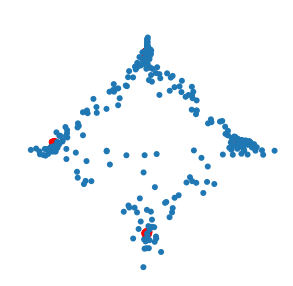

 80%|████████  | 1201/1500 [03:12<01:33,  3.21it/s]

accept
[[0.7828934], [0.7146863]]
reject


 80%|████████  | 1203/1500 [03:13<01:37,  3.05it/s]

[[0.7146863], [0.7859692]]
accept
[[0.7859692], [0.73527575]]
reject


 80%|████████  | 1206/1500 [03:14<01:28,  3.33it/s]

[[0.7428986], [0.80267274]]
accept
[[0.80267274], [0.66708314]]
reject


 81%|████████  | 1208/1500 [03:14<01:31,  3.21it/s]

[[0.66708314], [0.72549784]]
reject


 81%|████████  | 1210/1500 [03:15<01:33,  3.10it/s]

[[0.7425908], [0.78482354]]
accept
[[0.78482354], [0.7482983]]
reject


 81%|████████  | 1212/1500 [03:16<01:34,  3.04it/s]

[[0.7482983], [0.75014997]]
accept
[[0.7698481], [0.71703666]]
reject


 81%|████████  | 1215/1500 [03:16<01:25,  3.32it/s]

[[0.71703666], [0.76468164]]
accept
[[0.76468164], [0.74595124]]
reject


 82%|████████▏ | 1223/1500 [03:17<00:56,  4.93it/s]

[[0.7104075], [0.764907]]
accept
[[0.764907], [0.74862087]]
accept
[[0.74862087], [0.66773164]]
accept
[[0.7561105], [0.7249385]]
accept
[[0.7249385], [0.7215175]]
reject


 82%|████████▏ | 1225/1500 [03:18<01:07,  4.06it/s]

[[0.7215175], [0.7559631]]
reject
[[0.7079631], [0.7220051]]
reject


 82%|████████▏ | 1227/1500 [03:19<01:42,  2.65it/s]

[[0.7220051], [0.80156636]]
accept
[[0.80156636], [0.7467088]]
accept
[[0.7505852], [0.7338308]]
reject


 82%|████████▏ | 1231/1500 [03:20<01:27,  3.09it/s]

[[0.7338308], [0.7974611]]
accept
[[0.7974611], [0.72121394]]
reject


 82%|████████▏ | 1234/1500 [03:21<01:18,  3.38it/s]

[[0.76260346], [0.7669099]]
reject


 82%|████████▏ | 1235/1500 [03:21<01:47,  2.47it/s]

[[0.7669099], [0.80192876]]
accept
[[0.80192876], [0.71817845]]
reject


 83%|████████▎ | 1238/1500 [03:22<01:33,  2.82it/s]

[[0.74336255], [0.76893413]]
accept
[[0.76893413], [0.6431347]]
accept
[[0.6431347], [0.6418137]]
reject


 83%|████████▎ | 1242/1500 [03:23<01:18,  3.27it/s]

[[0.7091812], [0.7699777]]
reject


 83%|████████▎ | 1243/1500 [03:24<01:48,  2.37it/s]

[[0.7699777], [0.79859614]]
reject


 83%|████████▎ | 1244/1500 [03:24<02:13,  1.92it/s]

[[0.79859614], [0.80069685]]
accept
[[0.79492974], [0.7227842]]
reject


 83%|████████▎ | 1247/1500 [03:25<01:51,  2.28it/s]

[[0.7227842], [0.74879605]]
accept
[[0.74879605], [0.68850183]]
accept
[[0.78407955], [0.7085413]]
reject


 83%|████████▎ | 1251/1500 [03:26<01:30,  2.76it/s]

[[0.7085413], [0.8205726]]
accept
[[0.8205726], [0.8195499]]
accept
[[0.79426765], [0.7814388]]
accept
[[0.7814388], [0.7265207]]
reject


 84%|████████▎ | 1256/1500 [03:27<01:13,  3.31it/s]

[[0.7265207], [0.74054676]]
reject


 84%|████████▍ | 1258/1500 [03:27<01:17,  3.13it/s]

[[0.7341511], [0.7441305]]
accept
[[0.7441305], [0.6661318]]
accept
[[0.6661318], [0.63582546]]
reject


 84%|████████▍ | 1262/1500 [03:28<01:06,  3.57it/s]

[[0.62759143], [0.6488392]]
reject


 84%|████████▍ | 1263/1500 [03:29<01:36,  2.47it/s]

[[0.6488392], [0.6648835]]
accept
[[0.6648835], [0.6135951]]
reject


 84%|████████▍ | 1266/1500 [03:29<01:23,  2.80it/s]

[[0.67682326], [0.69447315]]
reject


 84%|████████▍ | 1267/1500 [03:30<01:45,  2.21it/s]

[[0.69447315], [0.7017716]]
accept
[[0.7017716], [0.69986516]]
accept
[[0.686208], [0.6768645]]
reject


 85%|████████▍ | 1271/1500 [03:31<01:26,  2.66it/s]

[[0.6768645], [0.7548973]]
reject


 85%|████████▍ | 1272/1500 [03:32<01:49,  2.09it/s]

[[0.7548973], [0.7812122]]
reject


 85%|████████▍ | 1274/1500 [03:32<01:39,  2.27it/s]

[[0.7471973], [0.74743485]]
reject


 85%|████████▌ | 1275/1500 [03:33<01:58,  1.90it/s]

[[0.74743485], [0.7506928]]
reject


 85%|████████▌ | 1276/1500 [03:34<02:10,  1.71it/s]

[[0.7506928], [0.7681858]]
reject


 85%|████████▌ | 1278/1500 [03:34<01:55,  1.93it/s]

[[0.7040524], [0.74320686]]
accept
[[0.74320686], [0.72485954]]
reject


 85%|████████▌ | 1280/1500 [03:35<01:43,  2.12it/s]

[[0.72485954], [0.72495687]]
accept
[[0.64497286], [0.63086015]]
reject


 86%|████████▌ | 1283/1500 [03:36<01:28,  2.45it/s]

[[0.63086015], [0.68249476]]
reject


 86%|████████▌ | 1284/1500 [03:37<01:46,  2.02it/s]

[[0.68249476], [0.7490574]]
reject


 86%|████████▌ | 1286/1500 [03:37<01:38,  2.18it/s]

[[0.7125589], [0.7301577]]
accept
[[0.7301577], [0.69207174]]
reject


 86%|████████▌ | 1288/1500 [03:38<01:30,  2.34it/s]

[[0.69207174], [0.7168701]]
accept
[[0.764642], [0.72886646]]
reject


 86%|████████▌ | 1291/1500 [03:39<01:18,  2.67it/s]

[[0.72886646], [0.76716113]]
accept
[[0.76716113], [0.75113314]]
reject


 86%|████████▋ | 1294/1500 [03:40<01:09,  2.98it/s]

[[0.7441306], [0.76767385]]
accept
[[0.76767385], [0.7205433]]
reject


 86%|████████▋ | 1296/1500 [03:40<01:09,  2.92it/s]

[[0.7205433], [0.75885177]]
reject


 87%|████████▋ | 1298/1500 [03:41<01:10,  2.87it/s]

[[0.58544016], [0.6660369]]
reject


 87%|████████▋ | 1299/1500 [03:42<01:31,  2.20it/s]

[[0.6660369], [0.7036326]]
accept
[[0.7036326], [0.685951]]
[0.58711165]


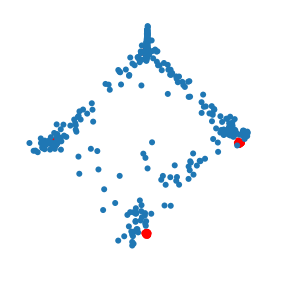

 87%|████████▋ | 1301/1500 [03:42<01:11,  2.76it/s]

reject


 87%|████████▋ | 1302/1500 [03:43<01:32,  2.15it/s]

[[0.58711165], [0.71415794]]
accept
[[0.71415794], [0.68957406]]
accept
[[0.68957406], [0.64003354]]
reject


 87%|████████▋ | 1306/1500 [03:44<01:14,  2.60it/s]

[[0.67313147], [0.7261111]]
accept
[[0.7261111], [0.7103057]]
reject


 87%|████████▋ | 1308/1500 [03:44<01:12,  2.63it/s]

[[0.7103057], [0.7808585]]
reject


 87%|████████▋ | 1310/1500 [03:45<01:11,  2.65it/s]

[[0.7164112], [0.7358825]]
accept
[[0.7358825], [0.6142343]]
reject


 87%|████████▋ | 1312/1500 [03:46<01:10,  2.67it/s]

[[0.6142343], [0.65937597]]
reject


 88%|████████▊ | 1314/1500 [03:47<01:09,  2.67it/s]

[[0.69026875], [0.70364356]]
reject


 88%|████████▊ | 1315/1500 [03:47<01:28,  2.10it/s]

[[0.70364356], [0.72734666]]
accept
[[0.72734666], [0.6510939]]
reject


 88%|████████▊ | 1318/1500 [03:48<01:14,  2.45it/s]

[[0.55465066], [0.6647593]]
accept
[[0.6647593], [0.65801245]]
reject


 88%|████████▊ | 1320/1500 [03:49<01:11,  2.53it/s]

[[0.65801245], [0.6660308]]
accept
[[0.7548664], [0.71519494]]
reject


 88%|████████▊ | 1323/1500 [03:49<01:02,  2.84it/s]

[[0.71519494], [0.7264873]]
accept
[[0.7264873], [0.66327465]]
reject


 88%|████████▊ | 1326/1500 [03:50<00:56,  3.07it/s]

[[0.6802012], [0.73702645]]
reject


 88%|████████▊ | 1327/1500 [03:51<01:18,  2.21it/s]

[[0.73702645], [0.7535215]]
reject


 89%|████████▊ | 1328/1500 [03:52<01:32,  1.87it/s]

[[0.7535215], [0.81266546]]
reject


 89%|████████▊ | 1330/1500 [03:53<01:23,  2.04it/s]

[[0.7369323], [0.76115453]]
accept
[[0.76115453], [0.7153573]]
reject


 89%|████████▉ | 1332/1500 [03:53<01:16,  2.20it/s]

[[0.7153573], [0.7468214]]
reject


 89%|████████▉ | 1334/1500 [03:54<01:11,  2.32it/s]

[[0.6465939], [0.67737144]]
reject


 89%|████████▉ | 1335/1500 [03:55<01:27,  1.89it/s]

[[0.67737144], [0.68459046]]
accept
[[0.68459046], [0.64237225]]
accept
[[0.70614326], [0.624455]]
reject


 89%|████████▉ | 1339/1500 [03:56<01:09,  2.33it/s]

[[0.624455], [0.7507017]]
accept
[[0.7507017], [0.71991783]]
accept
[[0.7938724], [0.7392328]]
reject


 90%|████████▉ | 1343/1500 [03:56<00:56,  2.78it/s]

[[0.7392328], [0.7723771]]
accept
[[0.7723771], [0.6391972]]
accept
[[0.76677704], [0.65565956]]
reject


 90%|████████▉ | 1347/1500 [03:57<00:47,  3.20it/s]

[[0.65565956], [0.6610166]]
reject


 90%|████████▉ | 1348/1500 [03:58<01:08,  2.23it/s]

[[0.6610166], [0.6850314]]
accept
[[0.6738148], [0.6198592]]
reject


 90%|█████████ | 1351/1500 [03:59<00:58,  2.56it/s]

[[0.6198592], [0.71146446]]
accept
[[0.71146446], [0.6701611]]
reject


 90%|█████████ | 1354/1500 [03:59<00:51,  2.82it/s]

[[0.67005175], [0.7007792]]
accept
[[0.7007792], [0.5743152]]
reject


 90%|█████████ | 1356/1500 [04:00<00:52,  2.76it/s]

[[0.5743152], [0.61796]]
reject


 91%|█████████ | 1358/1500 [04:01<00:52,  2.70it/s]

[[0.61726594], [0.7160584]]
accept
[[0.7160584], [0.6782454]]
accept
[[0.6782454], [0.5737498]]
reject


 91%|█████████ | 1362/1500 [04:02<00:44,  3.14it/s]

[[0.5521316], [0.6878333]]
reject


 91%|█████████ | 1363/1500 [04:03<01:00,  2.25it/s]

[[0.6878333], [0.68852615]]
accept
[[0.68852615], [0.6849405]]
reject


 91%|█████████ | 1366/1500 [04:03<00:52,  2.55it/s]

[[0.6987299], [0.7647681]]
accept
[[0.7647681], [0.68241036]]
accept
[[0.68241036], [0.67086387]]
accept
[[0.7183069], [0.71080697]]
reject


 91%|█████████▏| 1371/1500 [04:04<00:41,  3.09it/s]

[[0.71080697], [0.7551857]]
reject


 91%|█████████▏| 1372/1500 [04:05<01:00,  2.11it/s]

[[0.7551857], [0.75606763]]
accept
[[0.72756934], [0.69093466]]
reject


 92%|█████████▏| 1375/1500 [04:06<00:51,  2.42it/s]

[[0.69093466], [0.71775943]]
reject


 92%|█████████▏| 1376/1500 [04:07<01:04,  1.91it/s]

[[0.71775943], [0.7336881]]
reject


 92%|█████████▏| 1378/1500 [04:07<00:59,  2.06it/s]

[[0.753435], [0.75879097]]
accept
[[0.75879097], [0.7238064]]
accept
[[0.7238064], [0.713823]]
reject


 92%|█████████▏| 1382/1500 [04:08<00:47,  2.48it/s]

[[0.7412511], [0.74258614]]
accept
[[0.74258614], [0.62359613]]
accept
[[0.62359613], [0.61606586]]
reject


 92%|█████████▏| 1386/1500 [04:09<00:39,  2.90it/s]

[[0.6054608], [0.61675525]]
reject


 92%|█████████▏| 1387/1500 [04:10<00:55,  2.05it/s]

[[0.61675525], [0.6261885]]
reject


 93%|█████████▎| 1388/1500 [04:11<01:05,  1.72it/s]

[[0.6261885], [0.64100945]]
reject


 93%|█████████▎| 1390/1500 [04:12<00:57,  1.90it/s]

[[0.63646615], [0.6520575]]
accept
[[0.6520575], [0.5956476]]
reject


 93%|█████████▎| 1392/1500 [04:12<00:52,  2.07it/s]

[[0.5956476], [0.6414361]]
reject


 93%|█████████▎| 1394/1500 [04:13<00:48,  2.18it/s]

[[0.661109], [0.69423556]]
accept
[[0.69423556], [0.68602663]]
reject


 93%|█████████▎| 1396/1500 [04:14<00:46,  2.26it/s]

[[0.68602663], [0.7014425]]
accept
[[0.68041456], [0.6417266]]
accept
[[0.6417266], [0.6115611]]
reject


 93%|█████████▎| 1400/1500 [04:15<00:37,  2.68it/s]

[[0.6115611], [0.6802616]]
[0.6779665]


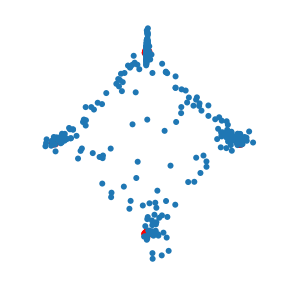

 93%|█████████▎| 1401/1500 [04:15<00:33,  2.92it/s]

accept
[[0.6779665], [0.67380726]]
reject


 94%|█████████▎| 1403/1500 [04:16<00:34,  2.79it/s]

[[0.67380726], [0.6927187]]
reject


 94%|█████████▎| 1404/1500 [04:17<00:46,  2.08it/s]

[[0.6927187], [0.7571057]]
accept
[[0.77830553], [0.6971326]]
reject


 94%|█████████▍| 1407/1500 [04:17<00:39,  2.38it/s]

[[0.6971326], [0.72204506]]
reject


 94%|█████████▍| 1408/1500 [04:18<00:48,  1.89it/s]

[[0.72204506], [0.7252513]]
reject


 94%|█████████▍| 1410/1500 [04:19<00:43,  2.05it/s]

[[0.6828256], [0.72982645]]
accept
[[0.72982645], [0.6632409]]
reject


 94%|█████████▍| 1412/1500 [04:20<00:40,  2.15it/s]

[[0.6632409], [0.76842386]]
reject


 94%|█████████▍| 1414/1500 [04:21<00:39,  2.20it/s]

[[0.611156], [0.62895596]]
reject


 94%|█████████▍| 1415/1500 [04:21<00:46,  1.82it/s]

[[0.62895596], [0.75725687]]
accept
[[0.75725687], [0.70478487]]
accept
[[0.71546304], [0.6719348]]
reject


 95%|█████████▍| 1424/1500 [04:22<00:24,  3.12it/s]

[[0.6719348], [0.6900765]]
accept
[[0.6900765], [0.68664026]]
accept
[[0.78037745], [0.70778245]]
accept
[[0.70778245], [0.7047184]]
accept
[[0.7047184], [0.6873948]]
accept
[[0.6891476], [0.6849382]]
accept
[[0.6849382], [0.66182935]]
reject


 95%|█████████▌| 1428/1500 [04:23<00:20,  3.45it/s]

[[0.66182935], [0.7594284]]
accept
[[0.71895134], [0.7008138]]
accept
[[0.7008138], [0.6518724]]
reject


 95%|█████████▌| 1432/1500 [04:24<00:18,  3.66it/s]

[[0.6518724], [0.66328865]]
accept
[[0.71439356], [0.6995084]]
accept
[[0.6995084], [0.6991428]]
reject


 96%|█████████▌| 1436/1500 [04:25<00:16,  3.87it/s]

[[0.6991428], [0.72383237]]
reject


 96%|█████████▌| 1438/1500 [04:26<00:18,  3.33it/s]

[[0.69098234], [0.6951033]]
accept
[[0.6951033], [0.68253416]]
reject


 96%|█████████▌| 1440/1500 [04:27<00:20,  2.98it/s]

[[0.68253416], [0.69815564]]
accept
[[0.7265401], [0.69268465]]
reject


 96%|█████████▌| 1443/1500 [04:28<00:18,  3.14it/s]

[[0.69268465], [0.72284245]]
accept
[[0.72284245], [0.65378404]]
reject


 96%|█████████▋| 1446/1500 [04:28<00:16,  3.27it/s]

[[0.71689314], [0.71750987]]
reject


 96%|█████████▋| 1447/1500 [04:29<00:23,  2.24it/s]

[[0.71750987], [0.72418743]]
accept
[[0.72418743], [0.7129593]]
reject


 97%|█████████▋| 1450/1500 [04:30<00:19,  2.52it/s]

[[0.70994747], [0.72156304]]
accept
[[0.72156304], [0.6727905]]
reject


 97%|█████████▋| 1452/1500 [04:31<00:19,  2.52it/s]

[[0.6727905], [0.70516396]]
accept
[[0.69366515], [0.6875893]]
reject


 97%|█████████▋| 1455/1500 [04:32<00:16,  2.77it/s]

[[0.6875893], [0.6913973]]
reject


 97%|█████████▋| 1456/1500 [04:32<00:21,  2.05it/s]

[[0.6913973], [0.7135237]]
accept
[[0.6629147], [0.64620835]]
reject


 97%|█████████▋| 1459/1500 [04:33<00:17,  2.36it/s]

[[0.64620835], [0.76215106]]
accept
[[0.76215106], [0.6744237]]
reject


 97%|█████████▋| 1462/1500 [04:34<00:14,  2.60it/s]

[[0.6774789], [0.7079098]]
reject


 98%|█████████▊| 1463/1500 [04:35<00:18,  1.99it/s]

[[0.7079098], [0.7470072]]
accept
[[0.7470072], [0.66986114]]
reject


 98%|█████████▊| 1466/1500 [04:36<00:14,  2.30it/s]

[[0.72303295], [0.7380123]]
accept
[[0.7380123], [0.7194214]]
accept
[[0.7194214], [0.67956686]]
reject


 98%|█████████▊| 1470/1500 [04:37<00:11,  2.70it/s]

[[0.7474247], [0.7501643]]
accept
[[0.7501643], [0.6937573]]
reject


 98%|█████████▊| 1472/1500 [04:38<00:11,  2.38it/s]

[[0.6937573], [0.7107257]]
accept
[[0.71734947], [0.66505694]]
accept
[[0.66505694], [0.6478897]]
reject


 98%|█████████▊| 1476/1500 [04:39<00:08,  2.77it/s]

[[0.6478897], [0.67338425]]
reject


 99%|█████████▊| 1478/1500 [04:39<00:08,  2.61it/s]

[[0.6106155], [0.6382508]]
reject


 99%|█████████▊| 1479/1500 [04:40<00:11,  1.90it/s]

[[0.6382508], [0.6887046]]
accept
[[0.6887046], [0.6652536]]
accept
[[0.64997363], [0.5882915]]
reject


 99%|█████████▉| 1483/1500 [04:41<00:07,  2.29it/s]

[[0.5882915], [0.6135006]]
reject


 99%|█████████▉| 1484/1500 [04:42<00:09,  1.78it/s]

[[0.6135006], [0.7050743]]
accept
[[0.66841984], [0.6544441]]
reject


 99%|█████████▉| 1487/1500 [04:43<00:06,  2.08it/s]

[[0.6544441], [0.66272163]]
reject


 99%|█████████▉| 1488/1500 [04:44<00:06,  1.72it/s]

[[0.66272163], [0.7137131]]
reject


 99%|█████████▉| 1490/1500 [04:45<00:05,  1.88it/s]

[[0.7235992], [0.7807909]]
accept
[[0.7807909], [0.71015453]]
reject


 99%|█████████▉| 1492/1500 [04:45<00:03,  2.01it/s]

[[0.71015453], [0.7521939]]
reject


100%|█████████▉| 1494/1500 [04:46<00:02,  2.11it/s]

[[0.6911771], [0.73609614]]
accept
[[0.73609614], [0.7344672]]
reject


100%|█████████▉| 1496/1500 [04:47<00:01,  2.17it/s]

[[0.7344672], [0.74573135]]
reject


100%|█████████▉| 1498/1500 [04:48<00:00,  2.24it/s]

[[0.6222023], [0.69622076]]
reject


100%|██████████| 1500/1500 [04:49<00:00,  5.19it/s]

[[0.69622076], [0.7725458]]
accept
[[0.7725458], [0.6193458]]


In [10]:
from tqdm import tqdm
xmax = 3
fs = []
frames = []
np_samples = []
n_batches_viz = 100
viz_every = params['viz_every']

#initialize at a very high loss value (to ensure that the first step is accepted)
f = [10000000]

for i in tqdm(range(params['max_iter'])):

    
    disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")
    gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
    
    
    fs.append(f)
    

    disc_steps = params['disc_steps']
    
    rate = params['rate']


    #Accept/reject step
    if i%rate != 0:
        
        #copy the current generator and discriminator weights in case the algorithm decides to go back to them later
        gen_vars_old = sess.run(gen_vars)
        disc_vars_old = sess.run(disc_vars)
        
        #take one generator gradient update and one discriminator gradient update
        f_new, _, _ = sess.run([[unrolled_loss, loss], g_train_op, d_train_op])


        #take the additional discriminator updates
        for disc_steps  in range(0, disc_steps-1):
            f_new, _ = sess.run([[loss], d_train_op])
            
            
        #Keep the weights which lead to the smaller loss    
        if f_new > f:
            print("reject")
            #If the old weights are better, replace the new weights with the old weights
            sess.run(tf.assign(gen_vars[0], gen_vars_old[0]))
            sess.run(tf.assign(gen_vars[1], gen_vars_old[1]))   
            sess.run(tf.assign(gen_vars[2], gen_vars_old[2])) 
            sess.run(tf.assign(gen_vars[3], gen_vars_old[3]))
            sess.run(tf.assign(gen_vars[4], gen_vars_old[4]))    
            sess.run(tf.assign(gen_vars[5], gen_vars_old[5])) 
        else:
            print("accept")
        print([f, f_new])
        f = f_new
    
    else:
        #take one generator gradient update and one discriminator gradient update
        f_new, _, _ = sess.run([[unrolled_loss, loss], g_train_op, d_train_op])
        
        #take the additional discriminator gradient updates
        for disc_steps  in range(0, disc_steps-1):
             f_new, _ = sess.run([[loss], d_train_op])
        
        f = f_new
                        
    
    
    
    #plot the output
    if i % viz_every == 0:
        print(f)
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
        fig = figure(figsize=(5,5))
        scatter(yy[:, 0], yy[:, 1], c='r', edgecolor='none')
        scatter(xx[:, 0], xx[:, 1], edgecolor='none')
        axis('off')
        plt.xlim(-1.5, 1.5)
        plt.ylim(-1.5, 1.5)
        
        #Save the plots (commented out here)
        #folder ='results'
        #plt.savefig(folder+'/our_algorithm_4Gaussians %d.png' %i)
        
        if generate_movie:
            frames.append(mplfig_to_npimage(fig))
        show()